In [1]:
# preparation
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
%matplotlib inline

from prml.dimreduction import Autoencoder, BayesianPCA, PCA

np.random.seed(1234)
iris = datasets.load_iris()

在第9章中，我们讨论了具有离散潜在变量的概率模型，例如高斯混合模型。我们现在研究某些潜在变量或者全部潜在变量为连续变量的模型。研究这种模型的一个重要的动机是许多数据集具有下面的性质：数据点几乎全部位于比原始数据空间的维度低得多的流形中。为了说明 为什么会出现这种现象，考虑一个人造的数据集，这个数据集将一个$ 64 \times 64 $ 的灰度图像表 示的手写数字嵌入到一个$ 100 \times 100 $的更大的图像中，用灰度值为零的像素（对应于白色像素）填充，并且数字的位置和方向被随机改变，如图12.1所示。

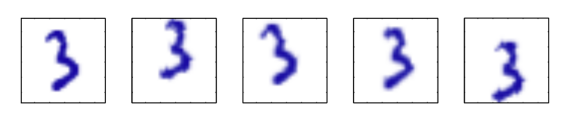

In [3]:
# 图12.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.1.png')
plt.axis('off')
ax.imshow(d)


图 12.1 一个人工生成的数据集，以手写数字图像为输入，创建出多个副本，每个副本中，数字都在一个更大的图像中进行了一个随机的平移和旋转。每个生成的图像都有$ 100 \times 100 = 10,000 $个像素。

每个生成的图像都可以表示 为$ 100 \times 100 = 10,000 $维数据空间内的一个点。然而，对于这种图像的数据集，只有三个变化的自由度（degrees of freedom），对应于垂直平移、水平平移和旋转。于是，数据点会位于数据空间的一个子空间中，它的本质维度（intrinsic dimensionality）等于3。注意，这个流形是非线性的，因为例如如果我们把数字移过一个特定的像素，那么像素值会从0（白色）变为1（黑 色），然后再回到0，这显然是数字位置的一个非线性函数。在这个例子中，平移和旋转变量是潜在变量，因为我们值观测到图像向量，不知道创建它们所使用的平移或者旋转变量。

对于真实的手写数字图像数据，会存在另外一个自由度，这个自由度产生于图像的缩放。并且还会存在更多的自由度，这些自由度与更加复杂的形变有关，这些复杂的形变来自一个人的各次书写之间的变化，以及不同人之间的书写风格的差异。尽管这样，这种自由度与数据集的 维度相比仍然很小。

另一个例子来源于石油流数据集，其中（对于给定的天然气、水、石油的几何配置）只有两个自由度，对应于管道中石油的比例和硕的比例（之后就可以确定天然气的比例）。虽然数据空间由12个度量组成，但是一组数据点会近似位于这个空间内的一个二维流形当中。在这种情况下，流形由几个不同的片段组成，对应于不同的流的形式，每一个片段都是一个（带有噪声 的）连续二维流形。如果我们的目标是数据压缩，或者对概率密度建模，那么利用这个流形结 构是很有用的。

在实际应用中，数据点不会被精确限制在一个光滑的低维流形中，我们可以将数据点关于流形的偏移看做噪声。这就自然地引出了这种模型的生成式观点，其中我们首先根据某种潜在变量的概率分布在流形中选择一个点，然后通过添加噪声的方式生成观测数据点。噪声服从给定 潜在变量下的数据变量的某个条件概率分布。

最简单的连续潜在变量模型对潜在变量和观测变量都作出了高斯分布的假设，并且使用了观测变量对于潜在变量状态的线性高斯依赖关系。这就引出了一个著名的技术——主成分分析（PCA）的概率表示形式，也引出了一个相关的模型，被称为因子分析。

本章中，我们首先介绍标准的、非概率的PCA方法，然后我们会说明，当求解线性高斯潜在变量模型的一种特别形式的最大似然解时，PCA如何自然地产生。这种概率形式的表示方法会带来很多好处，例如在参数估计时可以使用EM算法，对混合PCA模型的推广，以及主成分的数量可以从数据中自动确定的贝叶斯公式。最后，我们简短地讨论潜在变量概念的几个推广，使 得潜在变量的概念不局限于线性高斯假设。这种推广包括非高斯潜在变量，它引出了独立成分分析（independent conponent analysis）的框架。这种推广还包括潜在变量与观测变量的关系是 非线性关系的模型。

# 12.1 主成分分析

主成分分析，或称为PCA，是一种被广泛使用的技术，应用的领域包括维度降低、有损数据压缩、特征抽取、数据可视化（Jolliffe, 2002）。它也被称为Karhunen-Loeve变换。

有两种经常使用的PCA的定义，它们会给出同样的算法。PCA可以被定义为数据在低维线性空间上的正交投影，这个线性空间被称为主子空间（principal subspace），使得投影数据的方差被最大化（Hotelling, 1933）。等价地，它也可以被定义为使得平均投影代价最小的线性投影。平均投影代价是指数据点和它们的投影之间的平均平方距离（Pearson, 1901）。正交投影的过程如图12.2所示。

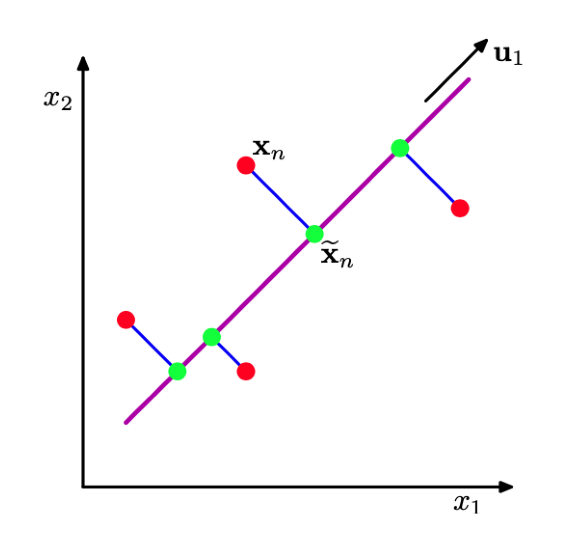

In [4]:
# 图12.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.2.png')
plt.axis('off')
ax.imshow(d)

图 12.2 主成分分析寻找一个低维空间，被称为主子平面,用紫色的线表示，使得数据点（红点）在子空间上的正交投影能够最大化投影点（绿点）的方差。PCA的另一个定义基于的是投影误差的平方和的最小值，用蓝线表示。

我们依次讨论这些定义。

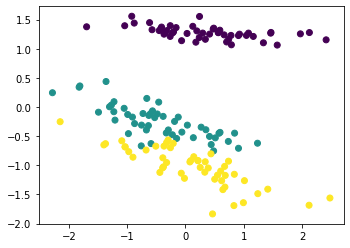

In [3]:
# plot
pca = PCA(n_components=2)
Z = pca.fit_transform(iris.data)
plt.scatter(Z[:, 0], Z[:, 1], c=iris.target)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 12.1.1 最大方差形式

考虑一组观测数据集$ {x_n} $，其中$ n = 1,...,N $，因此$ x_n $是一个$ D $维欧几里得空间中的变量。 我们的目标是将数据投影到维度$ M < D $的空间中，同时最大化投影数据的方差。现阶段，我们假设$ M $的值是给定的。稍后在本章中，我们会研究从数据中确定合适的$ M $值的方法。

首先，考虑在一维空间$ (M = 1) $上的投影。我们可以使用$ D $维向量$ u_1 $定义这个空间的方向。为了方便（并且不失一般性），我们假定选择一个单位向量，从而$ u_1^Tu_1 = 1 $（注意，我们只对$ u_1 $的方向感兴趣，而对$ u_1 $本身的大小不感兴趣）。这样，每个数据点$ x_n $被投影到一个标量值$ u_1^Tx_n $上。投影数据的均值是$ u_1^T\bar{x} $，其中，$ \bar{x} $是样本集合的均值，形式为
$ \bar{x} = \frac{1}{N}\sum\limits_{n=1}^Nx_n \tag{12.1} $
投影数据的方差为
$ \frac{1}{N}\sum\limits_{n=1}^N{u_1^Tx_n - t_1^T\bar{x}}^2 = u_1^TSu_1 \tag{12.2} $
其中$ S $是数据的协方差矩阵，定义为
$ S = \frac{1}{N}\sum\limits_{n=1}^N(x_n - \bar{x})(x_n - \bar{x})^T \tag{12.3} $
我们现在关于$ u_1 $最大化投影方差$ u_1^TSu_1 $。很明显，最大化的过程必须满足一定的限制来防止$ \Vert u_1 \Vert \to \infty $。恰当的限制来自标准化条件$ u_1^Tu_1 = 1 $。为了强制满足这个限制，我们引入拉格 朗日乘数，记作$ \lambda_1 $，然后对下式进行一个无限制的最大化
$ u_1^TSu_1 + \lambda_1(1 - u_1^Tu_1) \tag{12.4} $
通过令它关于$ u_1 $的导数等于0，我们看到驻点满足
$ Su_1 = \lambda_1u_1 \tag{12.5} $
这表明$ u_1 $一定是$ S $的一个特征向量。如果我们左乘$ u_1^T $，使用$ u_1^Tu_1 = 1 $，我们看到方差为
$ u_1^TSu_1 = \lambda_1 \tag{12.6} $
因此当我们将$ u_1 $设置为与具有最大的特征值$ \lambda_1 $的特征向量相等时，方差会达到最大值。这个特 征向量被称为第一主成分。

我们可以用一种增量的方式定义额外的主成分，方法为：在所有与那些已经考虑过的方向正交的所有可能的方向中，将新的方向选择为最大化投影方差的方向。如果我们考虑$ M $维投影空间的一般情形，那么最大化投影数据方差的最优线性投影由数据协方差矩阵$ S $的$ M $个特征向量$ u_1,...,u_M $定义，对应于$ M $个最大的特征值$ \lambda_1,...,\lambda_M $。可以通过归纳法很容易地证明出来。

总结一下，主成分分析涉及到计算数据集的均值$ \bar{x} ̄$和协方差矩阵$ S $，然后寻找$ S $的对应于$ M $个最大特征值的$ M $个特征向量。寻找特征值和特征向量的算法以及与特征向量分解相关的定理，可以参考Golub and Van Loan(1996)。注意，计算一个$ D \times D $矩阵的完整的特征向量分解的代价为$ O(D^3) $。如果我们计划将我们的数据投影到前$ M $个主成分中，那么我们只需寻找前$ M $个特征值和特征向量。这可以使用更高效的方法得到，例如幂方法（power method）（Golub and Van Loan, 1996），它的时间复杂度为$ O(MD^2) $，或我们也可以使用EM算法。



## 12.1.2 最小误差形式

我们现在讨论PCA的另一种形式，基于误差最小化的投影。为了完成这一点，我们引入$ D $维基向量的一个完整的单位正交集合$ {u_i} $，其中$ i = 1,...,D $，且满足
$ u_i^Tu_j = \delta_{ij} \tag{12.7} $
由于基是完整的，因此每个数据点可以精确地表示为基向量的一个线性组合，即
$ x_n = \sum\limits_{i=1}^D\alpha_{ni}u_i \tag{12.8} $
其中，系数$ \alpha_{ni} $对于不同的数据点来说是不同的。这对应于将坐标系旋转到了一个由$ {u_i} $定义的新坐标系，原始的$ D $个分量$ {x_{n1}|,...,x_{nD}} $被替换为一个等价的集合$ {\alpha_{n1},...,\alpha_{nD}} $。与$ u_j $做内积，然后使用单位正交性质，我们有$ \alpha_{nj} = x_n^Tu_j $，因此不失一般性，我们有
$ x_n = \sum\limits_{i=1}^D(x_n^Tu_i)u_i \tag{12.9} $
然而，我们的目标是使用限定数量$ M < D $个变量的一种表示方法来近似数据点，这对应于在低维子空间上的一个投影。不失一般性，$ M $维线性子空间可以用前$ M $个基向量表示，因此我们可以用下式来近似每个数据点$ x_n $
$ \tilde{x}n = \sum\limits{i=1}^Mz_{ni}u_i + \sum\limits_{i=M+1}^Db_iu_i \tag{12.10} $
其中$ {z_{ni}} $依赖于特定的数据点，而$ {bi} $是常数，对于所有数据点都相同。我们可以任意选择$ {u_i}, {z_{ni}} $和$ {b_i} $，从而最小化由维度降低所引入的失真。作为失真的度量，我们使用原始数据点与它的近似点$ \tilde{x}_n $之间的平方距离，在数据集上取平均。因此我们的目标是最小化
$ J = \frac{1}{N}\sum\limits_{n=1}^N\Vert x_n - \tilde{x}_n\Vert^2 \tag{12.11} $
首先考虑关于$ {z_{ni}} $的最小化。消去$ \tilde{x}n $令它关于$ t{nj} $的导数为0，然后使用单位正交的条件，我们有
$ z_{nj} = x_n^Tu_j \tag{12.12} $
其中$ j = 1,...,M $。类似的，令$ J $关于$ b_i $的导数等于0，再次使用单位正交的关系得到
$ b_j = \bar{x}^Tu_j \tag{12.13} $
其中$ j = M+1,...,D $。如果我们消去（12.10）中的$ z_{ni} $和$ b_i $，使用一般的展开式（12.9），得到
$ x_n - \tilde{x}n = \sum\limits{i=M+1}^D{(x_n - \bar{x})^Tu_i}u_i \tag{12.14} $
从中我们看到，从$ x_n $到$ \tilde{x}_n $的位移向量位于与主子空间垂直的空间中，因为它是$ {u_i} $的线性组合，其中$ i = M+1,...,D $，如图12.2所示。这与预期相符，因为投影点$ \tilde{x}_n $一定位于主子空间内，但是我们可以在那个子空间内自由移动投影点，因此最小的误差由正交投影给出。

于是，我们得到了失真度量$ J $的表达式，它是一个纯粹的关于$ {u_i} $的函数，形式为
$ J = \frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{i=M+1}^D(x_n^Tu_i - \bar{x}^Tu_i)^2 = \sum\limits_{i=M+1}^Du_i^TSu_i \tag{12.15} $
剩下的任务是关于$ {u_i} $对$ J $进行最小化，这必须是具有限制条件的最小化，因为如果不这样，我们会得到$ u_i = 0 $这一没有意义的结果。限制来自于单位正交条件，并且正如我们将看到的那样，解可以表示为协方差矩阵的特征向量展开式。在考虑一个形式化的解之前，让我们试着直观地考察一下这个结果。考虑二维数据空间$ D = 2 $以及一维主子空间$ M = 1 $的情形。我们必须选择一个方向$ u_2 $来最小化$ J = u_2^TSu_2 $，同时满足限制条件$ u_2^Tu_2 = 1 $。使用拉格朗日乘数$ \lambda_2 $来强制满足这个限制，我们考虑最小化
$ \tilde{J} = u_2^TSu_2 + \lambda_2(1 - u_2^Tu_2) \tag{12.16} $
令关于$ u_2 $的导数等于0，我们有$ Su_2 = \lambda_2u_2 $，从而$ u_2 $是$ S $的一个特征向量，且特征值为$ \lambda_2 $。因此任何特征向量都会定义失真度量的一个驻点。为了找到$ J $在最小值点处的值，我们将$ u_2 $的解代回到失真度量中，得到$ J = \lambda_2 $。于是，我们通过将$ u_2 $选择为对应于两个特征值中较小的那个特征值的特征向量，可以得到$ J $的最小值。因此，我们应该将主子空间与具有较大的特征值的特征向量对齐。这个结果与我们的直觉相符，即为了最小化平均平方投影距离，我们应该将主成分子空间选为穿过数据点的均值并且与最大方差的方向对齐。对于特征值相等的情形，任何主方向的选择都会得到同样的$ J $值。

对于任意的$ D $和任意的$ M < D $，最小化$ J $的一般解都可以通过将$ {u_i} $选择为协方差矩阵的特征向量的方式得到，即
$ Su_i = \lambda_iu_i \tag{12.17} $
其中$ i = 1,...,D $，并且与平常一样，特征向量$ {u_i} $被选为单位正交的。失真度量的对应的值为
$ J = \sum\limits_{i=M+1}^D\lambda_i \tag{12.18} $
这就是与主子空间正交的特征值的加和。于是，我们可以通过将这些特征向量选择成$ D − M $个最小的特征值对应的特征向量，来得到$ J $的最小值，因此定义了主子空间的特征向量是对应于$ M $个最大特征值的特征向量。
虽然我们已经考虑了$ M < D $的情形，但是PCA对于$ M = D $的情形仍然成立，这种情况下没有维度的降低，仅仅是将坐标轴旋转，与主成分对齐即可。

最后，值得注意的时，存在一个与此密切相关的线性维度降低的方法，被称为典型相关分析（canonical correlation analysis），或 CCA（Hotelling, 1936; Bach and Jordan, 2002）。PCA操作的对象是一个随机变量，而CCA考虑两个（或更多）的变量，并试图找到具有较高的交叉相关性的线性子空间对，从而在一个子空间中的每个分量都与另一个子空间的一个分量具有相关性。它的解可以表示为一般的特征向量问题。



## 12.1.3 PCA的应用

我们通过考虑离线手写数字数据集来说明PCA对于数据压缩的应用，其中我们关注与数字“3”的图像。由于协方差矩阵的每个特征向量是原始D维空间的一个向量，因此我们可以将特征向量表示为与数据点具有相同大小的图像。图12.3给出了前四个特征向量以及对应的特征值。

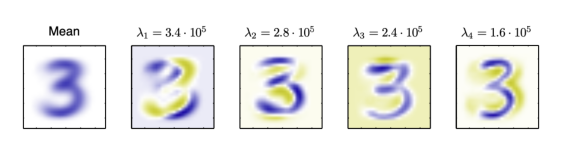

In [5]:
# 图12.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.3.png')
plt.axis('off')
ax.imshow(d)

图 12.3 对于离线手写数字数据集中的数字“3”，图中给出了均值向量$ x $以及前四个PCA特征向量$ u_1,...,u_4 $还有对应的特征值。蓝色对应于正值，白色对应于0，黄色对应于负值。

完整的特征值的图像，按照降序排序，如图12.4(a)所示。
 

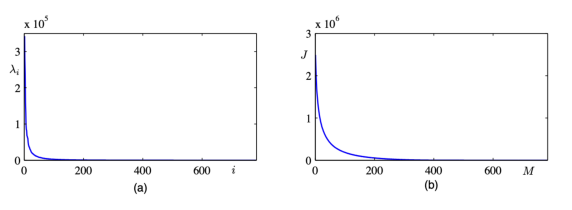

In [6]:
# 图12.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.4.png')
plt.axis('off')
ax.imshow(d)


图 12.4 (a)对于离线手写数字数据集里的数字“3”的特征值谱线。(b)丢弃的特征值的加和的图像，它表示将数据投影到$ M $维主成分子空间中引入的平方和失真$ J $。

选择$ M $的一个特定的值造成的失真度量$ J $由$ M + 1 $到$ D $的特征值的求和给出。对于不同的$ M $值，图像如图12.4(b)所示。
如果我们将式（12.12）和（12.13）代入（12.10），我们可以写出对数据向量$ x_n $的PCA近似，形式为
$ \begin{eqnarray} \tilde{x}n &=& \sum\limits{i=1}^M(x_n^Tu_i)u_i + \sum\limits_{i=M+1}^D(\bar{x}^Tu_i)u_i \tag{12.19} \\ &=& \bar{x} + \sum\limits_{i=1}^M(x_n^Tu_i - \bar{x}^Tu_i)u_i \tag{12.20} \end{eqnarray} $
其中我们使用了关系
$ \bar{x} = \sum\limits_{i=1}^D(\bar{x}^Tu_i)u_i \tag{12.21} $
这个关系来自于$ {ui} $的完整性。这种方法表示了对数据集的一个压缩，因为对于每个数据点，我们将$ D $维向量$ x_n $替换为$ M $维向量，元素为$ (x_n^Tu_i − \bar{x}^Tu_i) $。$ M $的值越小，压缩的程度越大。对于手写数字数据集里的数字“3”的数据点，使用PCA重建的例子如图12.5所示。

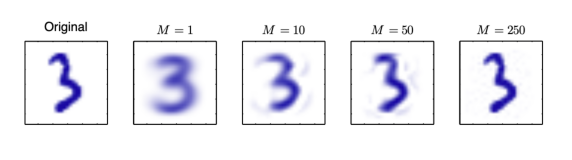

In [7]:
# 图12.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.5.png')
plt.axis('off')
ax.imshow(d)


 
图 12.5 来自离线手写数字数据集的原始样本，以及对于不同的$ M $值，保留M个主成分得到的PCA重建。 随着$ M $的增加，重建变得越来越精确。当$ M = D = 28 \times 28 = 784 $时，会得到一个完美的重建。

主成分分析的另一个应用是数据预处理。在这种情况下，目标不是维度降低，而是对数据集进行变换，使得数据集的某些属性得到标准化。这对于后续将模式识别算法成功应用于数据集来说很重要。通常，当原始变量使用不同的单位进行测量，或者变化情况相当不同的时候，我们会对数据集进行这样的变换。例如，在忠老泉数据集里，两次喷发的间隔时间通常要比喷发的持续时间大若干个数量级。当我们将K均值算法应用于这个数据集时，我们首先对各个变量进行单独的重新标度，使得每个变量的均值为0，方差为单位方差。这被称为对数据的标准化（standardize），并且标准化的数据的协方差矩阵的元素为
$ \rho_{ij} = \frac{1}{N}\sum\limits_{n=1}^N\frac{(x_{ni}-\bar{x}i)}{\sigma_i}\frac{(x{nj}-\bar{x}_j)}{\sigma_j} \tag{12.22} $
其中$ \sigma_i $是$ x_i $的标准差。这被称为原始数据集的相关性矩阵（correlation matrix），具有下面的性质：如果数据的两个分量$ x_i $和$ x_j $完全相关，那么$ \rho_{ij} = 1 $，如果它们不相关，那么$ rho_{ij} = 0 $。

然而，使用PCA，我们可以对数据进行更显著的标准化，得到零均值和单位方差的数据，从而不同的变量之间的相关性关系被消除。为了完成这一点，我们首先将特征向量方程（12.17）写成下面的形式
$ SU = UL $
其中，$ L $是一个$ D \times D $的对角矩阵，元素为$ \lambda_i $，$ U $是一个$ D \times D $的正交矩阵，列为$ u_i $。然后对于每个数据点$ x_n $，我们定义一个变换，值为
$ y_n = L^{-1/2}U^T(x_n - \bar{x}) \tag{12.24} $
其中$ \bar{x} $是式（12.1）定义的样本均值。很明显，集合$ {y_n} $的均值为0 ，协方差是单位矩阵 ，因为
$ \begin{eqnarray} \frac{1}{N}\sum\limits_{n=1}^Ny_ny_n^T &=& \frac{1}{N}\sum\limits_{n=1}^NL^{-1/2}U^T(x_n - \bar{x})(x_n - \bar{x})^TUL^{-1/2} \ &=& L^{-1/2}U^TSUL^{-1/2} = L^{-1/2}LL^{-1/2} = I \tag{12.25} \end{eqnarray} $
这个操作被称为对数据的白化（whitening）或球形化（sphereing）。图12.6使用忠老泉数据说明了这一点。
 

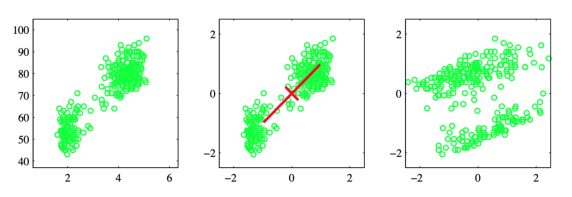

In [8]:
# 图12.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.6.png')
plt.axis('off')
ax.imshow(d)


图 12.6 对忠老泉数据集进行线性预处理的效果。左图给出的原始的数据。中图给出了将各个变量标准化为零均值单位方差的结果。同时画出的还有这个归一化数据集的主轴，画出了$ \pm\lambda 1/2 $的范围。右图给出了对数据进行白化的结果，得到了零均值单位协方差的数据。
将PCA与4.1.4节讨论的Fisher线性判别分析进行对比是很有趣的。两种方法都可以看成线性维度降低的例子。然而，PCA是无监督的，值依赖于$ x_n $的值，而Fisher线性判别分析还使用了 类别标签的信息。图12.7给出的例子强调了这个区别。
 

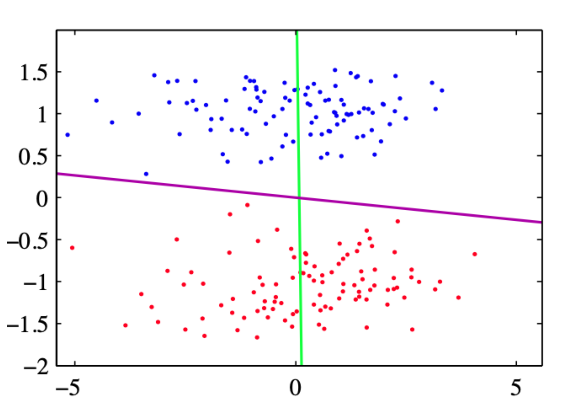

In [11]:
# 图12.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.7.png')
plt.axis('off')
ax.imshow(d)

图 12.7 用于线性维度降低的主成分分析与Fisher线性判别分析的对比。这里，数据位于二维空间中，属于两个类别，用红色和蓝色表示。数据要被投影到一维空间中。PCA选择了最大方差的方向，由紫色直线表示，它产生了严重的类别覆盖。而Fisher线性判别分析考虑类别标签,产生了在绿色直线上的投影。 这种投影对类别的区分效果要好得多。

主成分分析的另一个常见应用是数据可视化。这里，每个数据点被投影到二维$ (M = 2) $的主子空间中，从而数据点$ x_n $被画在了一个笛卡尔坐标系中，坐标系由$ x_n^Tu_1 $和$ x_n^Tu_2 $定义，其中$ u_1 $和$ u_2 $是特征向量，对应于最大的和第二大的特征值。对于石油流数据集，这种图的一个例 子如图12.8所示。
 

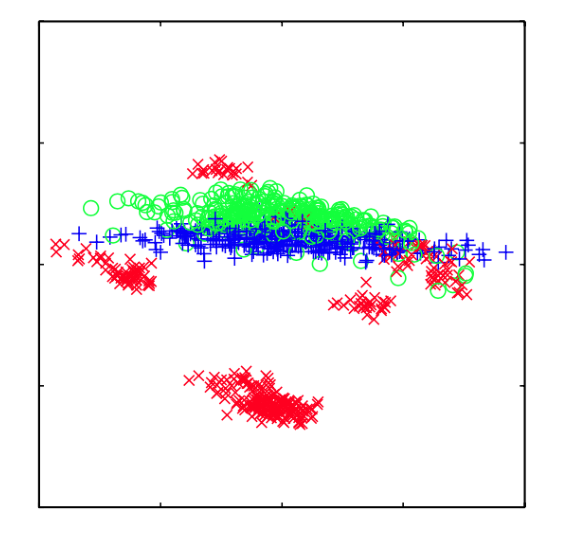

In [12]:
# 图12.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.8.png')
plt.axis('off')
ax.imshow(d)

图 12.8 石油流数据的可视化，通过将数据投影到前两个主成分上的方式实现。红色、蓝色和绿色点分别对应“薄片状”、“同质状”和“环状”的石油流配置。

## 12.1.4 高维数据的PCA

在主成分分析的一些应用中，数据点的数量小于数据空间的维度。例如，我们可能希望将PCA应用于由几百张图片组成的数据集，每个图片对应于几百万维（对应于图像中每个像素的三个颜色值）空间中的一个向量。注意，在一个$ D $维空间中，$ N $个数据点$ (N < D) $定义了一个线性子空间，它的维度最多为$ N − 1 $，因此在使用PCA时，几乎没有$ M $大于$ N − 1 $的数据点。实际上，如果我们运行PCA，我们会发现至少$ D − N + 1 $个特征值为0，对应于沿着数据集的方差为零的方向的特征向量。此外，通常的寻找$ D \times D $矩阵的特征向量的算法的计算代价为$ O(D^3) $，因此对于诸如图像这种应用来说，直接应用PCA在计算上是不可行的。

我们可以这样解这个问题。首先，让我们将$ X $定义为$ (N \times D) $维中心数据矩阵，它的第$ n $行为$ (x_n − \bar{x})^T $。这样，协方差矩阵（12.3）可以写成$ S = N^{−1}X^TX $， 对应的特征向量方程变成了
$ \frac{1}{N}X^TXu_i = \lambda_iu_i \tag{12.26} $
现在，将两侧左乘$ X $，可得
$ \frac{1}{N}XX^T(Xu_i) = \lambda_i(Xu_i) \tag{12.27} $
如果我们现在定义$ v_i = Xu_i $，那么我们有
$ \frac{1}{N}XX^Tv_i = \lambda_iv_i \tag{12.28} $
它是$ N \times N $矩阵$ N^{−1}XX^T $的一个特征向量方程。我们看到这个矩阵与原始的协方差矩阵具有相同的$ N − 1 $个特征值，原始的协方差矩阵本身有额外的$ D − N + 1 $个值为0的特征值。因此我们可以在低维空间中解决特征向量问题，计算代价为$ O(N^3) $而不是$ O(D^3) $。为了确定特征向量，我们将式（11.28）两侧乘以$ X^T $，可得
$ \left(\frac{1}{N}X^TX\right)(X^Tv_i) = \lambda_i(X^Tv_i) \tag{12.29} $
从中我们可以看到$ (X^Tv_i) $是$ S $的一个特征向量，对应的特征值为$ \lambda_i $。但是，需要注意，这些特征向量的长度未必等于1。为了确定合适的标准化，我们使用一个常数来对$ u_i \propto X^Tv_i $进行重新标度，使得$ \Vert u_i \Vert = 1 $。假设$ v_i $的长度已经被标准化，那么我们有
$ u_i = \frac{1}{(N\lambda_i)^{1/2}}X^Tv_i \tag{12.30} $
总结一下，为了应用这种方法，我们首先计算$ XX^T $，然后找到它的特征向量和特征值，之后使用式（12.30）计算原始数据空间的特征向量。



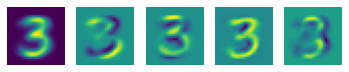

In [4]:
# plot
mnist = datasets.fetch_openml("mnist_784")
mnist3 = mnist.data[np.random.choice(np.where(mnist.target == '3')[0], 200)]
pca = PCA(n_components=4)
pca.fit(mnist3)
plt.subplot(1, 5, 1)
plt.imshow(pca.mean.reshape(28, 28))
plt.axis('off')
for i, w in enumerate(pca.W.T[::-1]):
    plt.subplot(1, 5, i + 2)
    plt.imshow(w.reshape(28, 28))
    plt.axis('off')
plt.show()

# 12.2 概率PCA

前一节讨论的PCA的形式所基于的是将数据线性投影到比原始数据空间维度更低的子空间内。我们现在说明，PCA也可以被视为概率潜在变量模型的最大似然解。PCA的这种形式，被称为概率PCA（probabilistic PCA），与传统的PCA相比，会带来如下几个优势。
- 概率PCA表示高斯分布的一个限制形式，其中自由参数的数量可以受到限制，同时仍然使 得模型能够描述数据集的主要的相关关系。
- 我们可以为PCA推导一个EM算法，这个算法在只有几个主要的特征向量需要求出的情况下，计算效率比较高，并且避免了计算数据协方差矩阵的中间步骤。
- 概率模型与EM的结合使得我们能够处理数据集里缺失值的问题。
- 概率PCA混合模型可以用一种有理有据的方式进行形式化，并且可以使用EM算法进行训练。
- 概率PCA构成了PCA的贝叶斯方法的基础，其中主子空间的维度可以自动从数据中找到。
- 似然函数的存在使得直接与其他的概率密度模型进行对比成为可能。相反，传统的PCA会给接近主子空间的数据点分配一个较低的重建代价，即使这些数据点的位置距离训练数据 任意远。
- 概率PCA可以被用来对类条件概率密度建模，因此可以应用于分类问题。
- 概率PCA模型可以用一种生成式的方式运行，从而可以按照某个概率分布生成样本。

这种概率模型形式的PCA由Tipping and Bishop(1997，1999b)和Roweis(1998)独立提出。正如我们后面将会看到的那样，它与因子分析(factor analysis)密切相关(Basilevsky， 1994)。

概率PCA是线性高斯框架的一个简单的例子，其中所有的边缘概率分布和条件概率分布都是高斯分布。我们可以按照下面的方式建立概率PCA模型。首先显式地引入潜在变量$ z $，对应于主成分子空间。接下来我们定义潜在变量上的一个高斯先验分布$ p(z) $以及以潜在变量的值为条件，观测变量$ x $的高斯条件概率分布$ p(x|z) $。具体来说，$ z $上的先验概率分布是一个0均值单位协方差的高斯分布
$ p(z) = \mathcal{N}(z|0,I) \tag{12.31} $
类似的，以潜在变量z的值为条件，观测变量x的条件概率分布还是高斯分布，形式为
$ p(x|z) = \mathcal{N}(x|Wz + \mu, \sigma^2I) \tag{12.32} $
其中$ x $的均值是$ z $的一个一般的线性函数，由$ D \times M $的矩阵$ W $和$ D $维向量$ \mu $控制。注意，可以关于$ x $的各个元素进行分解，换句话说，这是朴素贝叶斯模型的一个例子。正如我们稍后会看到 的那样，$ W $的列张成了数据空间的一个线性子空间，对应于主子空间。模型中的另一个参数$ \sigma^2 $控制了条件概率分布的方差。注意，我们可以不失一般性地假设潜在变量分布$ p(z) $服从一个0均值单位协方差的高斯分布，因为更一般的高斯分布会产生一个等价的概率模型。

我们可以从生成式的观点看待概率PCA模型，其中观测值的一个采样值通过下面的方式获得：首先为潜在变量选择一个值，然后以这个潜在变量的值为条件，对观测变量采样。具体来说，$ D $维观测变量$ x $由$ M $维潜在变量$ z $的一个线性变换附加一个高斯“噪声”定义，即
$ x = Wz + \mu + \epsilon \tag{12.33} $
其中$ z $是一个$ M $维高斯潜在变量，$ \epsilon $是一个$ D $维0均值高斯分布的噪声变量，协方差为$ \sigma^2I $。这个生成式过程如图12.9所示。

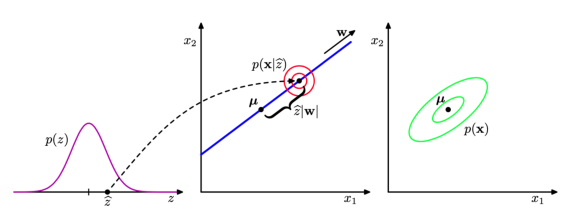

In [13]:
# 图12.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.9.png')
plt.axis('off')
ax.imshow(d)


图 12.9 概率PCA模型的生成式观点的说明，数据空间为二维，潜在空间为一维。一个观测数据点$ x $的生成方式为：首先从潜在变量的先验分布$ p(z) $中抽取一个潜在变量的值$ z $，然后从一个各向同性的高斯分布（用红色圆圈表示）中抽取一个$ x $的值，这个各向同性的高斯分布的均值为$ w\hat{z} + \mu $，协方差为$ \sigma^2I $。绿色椭圆画出了边缘概率分布$ p(x) $的密度等高线。

注意，这个框架基于的是从潜在空间到数据空间的一个映射，这与之前讨论的PCA的传统观点不同。从数据空间到潜在空间的逆映射可以通过使用贝叶斯定理的方式得到。

假设我们希望使用最大似然的方式确定参数$ W $， $ \mu $和$ \sigma^2 $的值。为了写出似然函数的表达式，我们需要观测变量的边缘概率分布$ p(x) $的表达式。根据概率的加法规则和乘积规则，边缘概率分布的形式为
$ p(x) = \int p(x|z)p(z)dz \tag{12.34} $
由于这对应于一个线性高斯模型，因此边缘概率分布还是高斯分布，形式为
$ p(x) = \mathcal{N}(x|\mu,C) \tag{12.35} $
其中$ D \times D $协方差矩阵$ C $被定义为
$ C = WW^T + \sigma^2I \tag{12.36} $
这个结果也可以更直接地推导出来。我们注意到预测概率分布是高斯分布，然后使用式（12.33）计算它的均值和协方差，结果为
$ \begin{eqnarray} \mathbb{E}[x] &=& \mathbb{E}[Wz + \mu + \epsilon] = \mu \tag{12.37} \\ cov[x] &=& \mathbb{E}[(Wz + \epsilon)(Wz + \epsilon)^T] \\ &=& \mathbb{E}[Wzz^TW^T] + \mathbb{E}[\epsilon\epsilon^T] = WW^T + \sigma^2I \tag{12.38} \end{eqnarray} $
其中我们使用了下面的事实：$ z $和$ \epsilon $是独立的随机变量，因此非相关。

直观地说，我们可以将概率分布$ p(x) $想象成由一个各向同性的高斯“喷雾罐”定义，然后将这个喷雾罐移过主子空间，喷射高斯分布的墨水，喷射的概率密度由$ \sigma^2 $定义，且权值为先验概率 分布。累积的墨水密度产生了“薄煎饼”形状的概率分布，表示边缘概率密度$ p(x) $。
预测分布$ p(x) $由参数$ \mu, W $和$ \sigma^2 $控制。然而，这些参数中存在冗余性，对应于潜在空间坐标的旋转。为了说明这一点，考虑一个矩阵$ \tilde{W} = WR $，其中$ R $是一个正交矩阵。使用正交性质$ RR^T = I $，我们看到协方差矩阵$ C $中的$ \tilde{W}\tilde{W}^T $的形式为
$ \tilde{W}\tilde{W}^T = WRR^TW^T = WW^T \tag{12.39} $
因此与$ R $独立。从而有一大类的矩阵$ \tilde{W} $会给出相同的预测分布。这种不变性可以理解为潜在空间中的旋转。我们稍后会回到对模型独立参数数量的讨论中。

当我们计算预测分布时，我们需要$ C^{−1} $，这涉及到对一个$ D \times D $的矩阵求逆。使用矩阵求逆的恒等式（C.7），所需的计算量可以被化简。使用这个矩阵恒等式得到的结果为
$ C^{-1} = \sigma^{-2}I - \sigma^{-2}WM^{-1}W^T \tag{12.40} $
其中$ M \times M $的矩阵$ M $的定义为
$ M = W^TW + \sigma^2I \tag{12.41} $
由于我们对$ M $进行求逆而不是直接对$ C $求逆，因此计算$ C^{−1} $从$ O(D^3) $减小到了$ O(M^3) $。
与预测分布$ p(x) $一样，我们也需要后验概率分布$ p(z|x) $，这可以直接使用式（2.116）给出的线性高斯模型的结果写出来，结果为
$ p(z|x) = \mathcal{N}(z|M^{−1}W^T(x−\mu),\sigma^2M^{−1}) \tag{12.42} $
注意，后验均值依赖于$ x $，而后验协方差与$ x $无关。




## 12.2.1 最大似然PCA

我们接下来考虑使用最大似然法确定模型的参数，给定观测数据点的数据点$ X = {x_n} $，概率PCA模型可以表示为一个有向图，如图12.10所示。
 

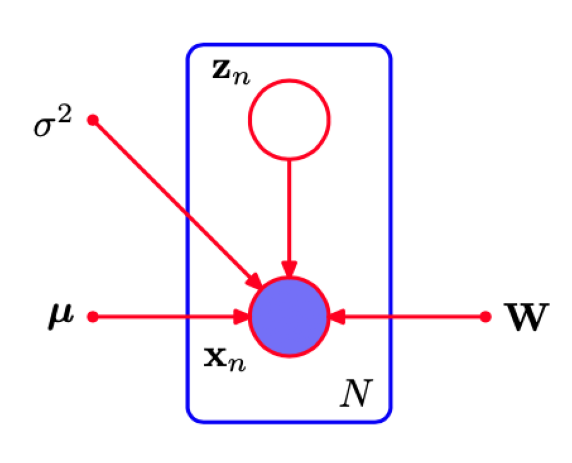

In [14]:
# 图12.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.10.png')
plt.axis('off')
ax.imshow(d)


图 12.10 对于观测变量$ x $的$ N $次观测组成的数据集，概率PCA模型可以表示为一个有向图，其中每个观测变量$ x_n $与潜在变量的$ z_n $的值相关联。

根据式（12.35），对应的对数似然函数为
$ \begin{eqnarray} \ln p(X|\mu,W,\sigma^2) &=& \sum\limits_{n=1}^N\ln p(x_n|W,\mu,\sigma^2) \ &=& -\frac{ND}{2}\ln(2\pi) - \frac{N}{2}\ln |C| - \frac{1}{2}\sum\limits_{n=1}^N(x_n - \mu)^TC^{-1}(x_n - \mu) \tag{12.43} \end{eqnarray} $
令似然函数关于$ \mu $的导数等于0，可以得到预期的结果$ \mu = \bar{x} $，其中$ \bar{x} $是式（12.1）定义的数据均值。代回到似然函数中得到
$ \ln p(X|W,\mu,\sigma^2) = -\frac{N}{2}{D\ln(2\pi) + \ln |C| + Tr(C^{-1}S)} \tag{12.44} $
其中$ S $是由式（12.3）定义的协方差矩阵。由于对数似然函数是$ \mu $的二次函数，因此解具有唯一的最大值，可以通过计算二阶导数的方式验证这一点。

关于$ W $和$ sigma^2 $的最大化更复杂，但是尽管这样，它们还是有一个近似的封闭解。Tipping and Bishop(1999b)证明，对数似然函数的所有驻点都可以写成
$ W_{ML} = U_M(L_M - \sigma^2I)^{1/2}R \tag{12.45} $
其中$ U_M $是一个$ D \times M $的矩阵，它的列由数据协方差矩阵$ S $的特征向量的任意（大小为$ M $的）子集给定。$ M \times M $的对角矩阵$ L_M $的元素是对应的特征值$ \lambda_i $，$ R $是一个任意的$ M \times M $的正交矩阵。

此外，Tipping and Bishop(1999b)证明，当$ M $个特征向量被选为前$ M $个最大的特征值所对应的特征向量时，对数似然函数可以达到最大值，其他所有的解都是鞍点。类似的结果由Roweis(1998)独立地提出猜想，但是未给出证明。同样的，我们假定特征向量按照对应的特征值的大小降序排列，从而$ M $个主特征向量是$ u_1,...,u_M $。在这种情况下，$ W $的列定义了标准PCA的主子空间。这样，$ \sigma^2 $的对应的最大似然解为
$ \sigma_{ML}^2 = \frac{1}{D-M}\sum\limits_{i=M+1}^D\lambda_i \tag{12.46} $
从而$ \sigma_{ML}^2 $是与丢弃的维度相关联的平均方差。

由于$ R $是正交的，因此它可以被看做是$ M $维潜在空间中的一个旋转矩阵。如果我们将$ W $的解代入到$ C $的表达式中，然后使用正交性质$ RR^T = I $，那么我们看到$ C $与$ R $无关。这表明，与之前讨论的一样，预测概率分布在潜在空间中具有旋转不变性。对于$ R = I $这一特定情形，我们看到$ W $的列是主成分特征向量，由方差参数的平方根$ \sqrt{\lambda_i − \sigma^2} $进行缩放。一旦我们认识到对于独立高斯分布（本例中的潜在空间分布和噪声模型）的卷积来说，方差是可加的，那么这些缩放因子的意义就很明显了。因此，在特征向量$ u_i $方向上的方差$ \lambda_i $由两部分相加得到，一部分来自于从单位方差潜在空间分布通过对应的$ W $的列向数据空间投影的贡献$ \lambda_i − \sigma^2 $，另一部分来自于在噪声模型的所有方向上相加的各项同性的方差的贡献$ \sigma^2 $。

值得花一些时间研究一下式（12.36）给出的协方差矩阵的形式。考虑预测分布在由单位向量$ v $指定的方向上的方差，其中$ v^Tv = 1 $，这个方差为$ v^TCv $。首先假设$ v $与主子空间正交，即它等于被丢弃的特征向量的某个线性组合。那么$ v^TU = 0 $，因此$ v^TCv = \sigma^2 $。所以模型预测了一个噪声方差正交于主子空间。根据公式(12.46)，这个方差就是丢弃的特征值的平均值。现在假设$ v = u_i $，其中$ u_i $是一个定义了主子空间的特征向量。那么$ v^TCv = (\lambda_i − \sigma^2) + \sigma^2 = \lambda_i $。换句话说，这个模型正确地描述了数据沿着主轴方向的方差，并且用一个单一的均值$ \sigma^2 $近似了所有剩余方向上的方差。

一种建立最大似然密度模型的方式是寻找数据协方差矩阵的特征值和特征向量，然后使用上面的结果计算$ W $和$ \sigma^2 $。在这种情况下，为了方便，我们会选择$ R = I $。然而，如果最大似然解通过对似然函数的数值最优化的方式得到，例如使用诸如共轭梯度法（Fletcher， 1987; Nocedal and Wright， 1999; Bishop and Nabney，2008）或EM算法，那么得到的$ R $值就可能是任意的了。 这表明$ W $的列不必是正交的。如果我们需要一组正交的基，那么矩阵$ W $可以进行恰当的后处理（Golub and Van Loan， 1996）。此外，EM算法可以进行修改，直接产生单位正交的主方向，按照对应的特征值降序排序（Ahn and Oh， 2003）。

潜在空间中的旋转不变性代表了一种形式的统计不可区分性，类似于我们在离散潜在变量的混合模型中遇到的情形。这里，有一组连续的参数会产生同样的预测密度，这不同于与混合模型中的分量重新标注相关联的离散不可区分性。

如果我们考虑$ M = D $的情形，从而不存在维度的降低，那么$ U_M = U $且$ L_M = L $。使用正交的性质$ UU^T = I $以及$ RR^T = I $，我们看到$ x $的边缘概率分布的协方差$ C $变成了
$ C = U(L - \sigma^2I)^{1/2}RR^T(L - \sigma^2I)^{1/2}U^T + \sigma^2I = ULU^T = S \tag{12.47} $
因此我们得到了无限制高斯分布的标准的最大似然解，其中协方差矩阵是样本的协方差。 传统的PCA通常的形式是$ D $维空间的数据点在$ M $维线性子空间上的投影。然而，概率PCA可以很自然地表示为从潜在空间到数据空间的映射，由式（12.33）给出。对于数据可视化和数据压缩之类的应用，我们可以使用贝叶斯定理将这个映射取逆。这样，任何在数据空间中的点$ x $都可以使用潜在空间中的后验均值和方差进行概括。根据式（12.42），均值为
$ \mathbb{E}[z|x] = M^{-1}W_{ML}^T(x-\bar{x}) \tag{12.48} $
其中$ M $由式（12.41）给出。它到数据空间的一个点的投影为
$ W\mathbb{E}[z|x] + \mu \tag{12.49} $
注意，这与正则化的线性回归方程的形式相同，结果是最大化了线性高斯模型的对数似然函数。类似的，式（12.42）的后验协方差为$ \sigma^2M^{−1} $，与$ x $无关。

如果我们取极限$ \sigma^2 \to 0 $，那么后验均值为
$ (W_{ML}^TW_{ML})^{-1}W_{ML}^T(x-\bar{x}) \tag{12.50} $
这表示数据点在潜在空间上的正交投影，因此我们就恢复出了标准的PCA模型。然而在这种极限情况下，后验协方差是零，概率密度变得奇异。对于$ \sigma^2 > 0 $的情形，潜在投影与正交投影相比，会向原点方向偏移。

最后，我们注意到，概率PCA模型在定义多元高斯分布时具有重要的作用，其中自由度的数量(即独立参数的数量)可以进行控制，同时仍然使得模型能够描述数据中的主要的相关关系。回忆一下，一个一般的高斯分布在协方差矩阵中有$ D(D+1) / 2 $个独立的参数（加上均值中的另外$ D $个参数）。因此参数的数量随着$ D $以二次函数的方式增多，从而在高位空间中变得无法处理。如果我们将协方差矩阵限制为对角化，那么它只有$ D $个独立的参数，从而此时参数的数量随着维度线性增长。然而，现在它对变量的处理方式类似于将变量看成是独立的，从而无法表达变量之间的相关性关系。概率PCA提供了一种优雅的折中方式，它能够描述$ M $个最显著的相关性关系，同时使得参数的总数随着$ D $线性增长。我们可以通过计算概率PCA模型的自由度的数量来理解这一点，如下所述。协方差矩阵$ C $依赖于参数$ W $（大小为$ D \times M $）和$ \sigma^2 $，从而总的参数数量为$ DM + 1 $。然而，我们已经看到参数中存在一些与潜在空间坐标系的旋转相关联的冗余性。表示这种旋转的正交矩阵$ R $的大小为$ M \times M $。这个矩阵的第一列有$ M − 1 $个独立的参数，因为列向量必须归一化到单位长度，第二列有$ M − 2 $个独立的参数，因为列向量必须被标准化，并且必须与前一列垂直，以此类推。对这个算术序列求和，我们看到$ R $总共有$ M(M −1) / 2 $个独立参数。因此协方差矩阵$ C $的自由度的数量为
$ DM + 1 - \frac{M(M-1)}{2} \tag{12.51} $
于是，对于固定的$ M $，这个模型中的独立参数的数量随着$ D $只是线性增长关系。如果我们令$ M = D − 1 $，那么我们就恢复出了高斯分布的完整的协方差矩阵的标准结果。在这种情况下，沿着$ D − 1 $个线性独立方向的方差由$ W $的列所控制，沿着剩余方向的方差由$ \sigma^2 $控制。如果$ M = 0 $，那么模型等价于各向同性协方差的情形。



## 12.2.2 用于PCA的EM算法

正如我们已经看到的那样，概率PCA模型可以根据连续潜在空间$ z $上的积分或求和来表示， 其中对于每个数据点$ x_n $，都存在一个对应的潜在变量$ z_n $。于是，我们可以使用EM算法来找到模型参数。这看起来似乎相当没有意义，因为我们已经得到了最大似然参数值的一个精确的解析解。然而，在高维空间中，使用迭代的EM算法而不是直接计算样本协方差矩阵可能会有一些计算上的优势。这个EM的求解步骤也可以推广到因子分析模型中，那里不存在解析解。最后，它使得我们可以用一种有理有据的方式处理缺失的数据。

我们可以使用一般的EM框架来推导用于概率PCA的EM算法。因此，我们写出完整数据对数似然函数，然后关于使用旧的参数值计算的潜在变量的后验概率分布求期望。最大化完整数据 对数似然函数的期望就会产生新的参数值。因为我们假定数据点是独立的，因此完整数据对数似然函数的形式为
$ \ln p(X,Z|\mu,W,\sigma^2) = \sum\limits_{n=1}^N{\ln p(x_n|z_n) + \ln p(z_n)} \tag{12.52} $
其中矩阵$ Z $的第$ n $行由$ z_n $给出。我们已经知道$ \mu $的精确的最大似然解是式（12.1）定义的样本均值$ \bar{x} $。在这个阶段将$ \mu $替换掉是比较方便的。分别使用式（12.31）和（12.32）给出的潜在概率分布和条件概率分布的表达式，然后关于潜在变量上的后验概率分布求期望，我们有
$$
\begin{array}{l}
\mathbb{E}\left[\ln p\left(\boldsymbol{X}, \boldsymbol{Z} \mid \boldsymbol{\mu}, \boldsymbol{W}, \sigma^{2}\right)\right]=-\sum_{n=1}^{N}\left\{\frac{D}{2} \ln \left(2 \pi \sigma^{2}\right)+\frac{1}{2} \operatorname{Tr}\left(\mathbb{E}\left[\boldsymbol{z}_{n} \boldsymbol{z}_{n}^{T}\right]\right)\right. \\
\quad+\frac{1}{2 \sigma^{2}}\left\|\boldsymbol{x}_{n}-\boldsymbol{\mu}\right\|^{2}-\frac{1}{\sigma^{2}} \mathbb{E}\left[\boldsymbol{z}_{n}\right]^{T} \boldsymbol{W}^{T}\left(\boldsymbol{x}_{n}-\boldsymbol{\mu}\right) \\
\left.\quad+\frac{1}{2 \sigma^{2}} \operatorname{Tr}\left(\mathbb{E}\left[\boldsymbol{z}_{n} \boldsymbol{z}_{n}^{T}\right] \boldsymbol{W}^{T} \boldsymbol{W}\right)+\frac{M}{2} \ln (2 \pi)\right\}
\end{array}
\tag{12.53} $$
注意，上式仅仅通过高斯分布的充分统计量对后验概率分布产生依赖。因此在E步骤中，我们使用旧的参数计算
$ \begin{eqnarray} \mathbb{E}[z_n] &=& M^{-1}W^T(x_n - \bar{x}) \tag{12.54} \\ \mathbb{E}[z_nz_n^T] &=& \sigma^2M^{-1} + \mathbb{E}[z_n]\mathbb{E}[z_n]^T \tag{12.55} \end{eqnarray} $
这可以直接从后验概率分布（12.42）以及标准的结果$ \mathbb{E}[z_nz_n^T] = cov[z_n] + \mathbb{E}[z_n]\mathbb{E}[z_n]^T $中得出。这里，$ M $由式（12.41）定义。


在M步骤中，我们关于$ W $和$ \sigma^2 $进行最大化，保持后验统计量固定。关于$ \sigma^2 $的最大化很容易。对于关于$ W $的最大化，我们可以使用（C.24）。求得的M步骤方程为
$ \begin{eqnarray} W_{new} &=& \left[\sum\limits_{n=1}^N(x_n - \bar{x})\mathbb{E}[z_n]^T\right]\left[\sum\limits_{n=1}^N\mathbb{E}[z_nz_n^T]\right]^{-1} \tag{12.56} \\ \sigma_{new}^2 &=& \frac{1}{ND}\sum\limits_{n=1}^N{\Vert x_n - \bar{x} \Vert^2 - 2\mathbb{E}[z_n]^TW_{new}^T(x_n - \bar{x}) \\ & & + Tr(\mathbb{E}[z_nz_n^T]W_{new}^TW_{new})} \tag{12.57} \end{eqnarray} $
概率PCA的EM算法的执行过程为：对参数进行初始化，然后交替地在E步骤中使用式（12.54）和（12.55）计算潜在空间的后验概率分布的充分统计量，以及在M步骤中使用式（12.56）和（12.57）来修正参数的值。


用于PCA的EM算法的一个好处是对于大规模应用的计算效率（Roweis，1998）。与传统的基于样本协方差矩阵的特征向量分解的PCA不同，EM算法时迭代的，因此似乎没有什么吸引力。 然而，在高维空间中，EM算法的每次迭代所需的计算量都要比传统的PCA小得多。为了说明这一点，我们注意到，对协方差矩阵的特征分解的计算复杂度为$ O(D^3) $。通常我们只对前$ M $个特征向量和它们的特征值感兴趣，这种情况下我们可以使用$ O(MD^2) $的算法。然而，计算协方差矩阵本身需要$ O(ND^2) $的计算量，其中$ N $是数据点的数量。有一些能够避免直接计算协方差矩阵的算法，例如快照方法（snapshot method）（Sirovich， 1987）假设特征向量是数据向量的线性组合，但是这种算法的计算复杂度为$ O(N^3) $，因此不适用于大规模数据。这里描述的EM算法也没有显式地建立协方差矩阵。相反，计算量最大的步骤是涉及到对数据集求和的操作，计算代价为$ O(NDM) $。对于较大的$ D,M \ll D $，这与$ O(ND^2) $相比，计算量极大地降低，因此可以抵消EM算法的迭代本质。

注意，这个EM算法可以用一种在线的形式执行，其中每个$ D $维数据点被读入、处理，然后在处理下一个数据点之前丢弃这个数据点。为了说明这一点，注意在E步骤中需要计算的量（一个$ M $维向量和一个$ M \times M $的矩阵）可以分别对每个数据点单独计算，在M步骤中，我们需要在数据点上累积求和，这个可以增量地完成。如果$ N $和$ D $都很大，那么这种方法会很有优势。

由于我们现在对PCA建立了一个完全的概率模型，因此我们可以通过对未观测变量进行积分或求和的方式，处理缺失的数据，假设数据的缺失是随机的。与之前一样，这些缺失值可以使用EM算法进行处理。我们在图12.11中给出了使用这种方法进行数据可视化的一个例子。

EM算法的另一个特征是，我们可以取极限$ \sigma^2 \to 0 $，对应于标准的PCA，仍然可以得到一 个合法的类似EM的算法（Roweis， 1998）。根据式（12.55），我们看到我们在E步骤中需要计算的唯一的量是$ \mathbb{E}[z_n] $。此外，M步骤可以得到简化，因为$ M = W^TW $。为了强调算法的简化，让我们将$ \tilde{X} $定义为一个$ N \times D $的矩阵，它的第$ n $行为向量$ x_n − \bar{x} $，类似地，定义$ \Omega $为一个$ M \times N $的矩阵，它的第$ n $行是向量$ \mathbb{E}[z_n] $。这样PCA的EM算法的E步骤（12.54）就变成了
$ \Omega = (W_{old}^TW_{old})^{-1}W_{old}^T\tilde{X}^T \tag{12.58} $
M步骤（12.56）的形式为
$ W_{new} = \tilde{X}^T\Omega^T(\Omega\Omega^T)^{-1} \tag{12.59} $
与之前一样，可以使用一种在线的方式执行。这些方程有一个很简单的意义，如下所述。根据我们之前的讨论，我们看到E步骤涉及到数据点在当前估计的主子空间上的正交投影。对应地，M步骤表示对主子空间的重新估计，使得平方重建误差最小，其中投影固定。

我们可以给出这个EM算法的一个简单的物理类比，这对于$ D = 2 $和$ M = 1 $的情形很容易进行可视化。考虑二维空间中的一组数据点，令一维主子空间用一个固体的杆表示。现在使用一个遵守胡克定律(存储的能量正比于弹簧长度的平方)的弹簧将每个数据点与杆相连。在E步骤中，我们保持杆固定，让附着的点沿着杆上下滑动，使得能量最小。这使得每个数据点独立的到达对应的数据点在杆上的正交投影的位置。在M步骤中，我们令附着点固定，然后松开杆，让杆达到能量最小的位置。然后E步骤和M步骤不断重复，直到满足一个收敛准则，如图12.12所示。



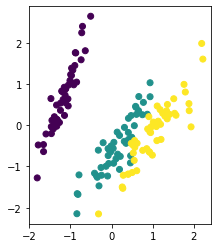

In [5]:
# plot
pca = PCA(n_components=2)
Z = pca.fit_transform(iris.data, method="em")
plt.scatter(Z[:, 0], Z[:, 1], c=iris.target)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 12.2.3 贝叶斯PCA

目前在我们关于PCA的讨论中，我们假定主子空间的维度$ M $是给定的。在实际应用中，我们必须根据应用选择一个合适的值。为了数据可视化，我们一般选择$ M = 2 $，而对于其他的应用，$ M $的合适的选择就没有这么明显了。一种方法是画出数据集的特征值谱线，类似于离线手写数字数据集的图12.4的例子，然后看特征值是否自然地分成了两组，一组由很小的值组成，另一组由相对较大的值组成，两组之间有一个很明显的区分，表示$ M $的选择存在一个很自然的值。在实际应用中，这种明显的区分通常无法看到。

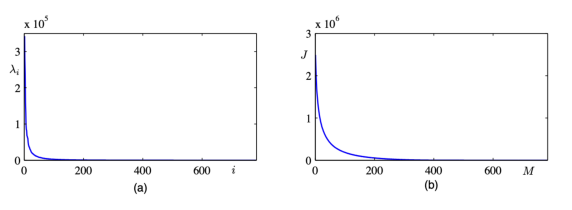

In [15]:
# 图12.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.4.png')
plt.axis('off')
ax.imshow(d)


由于概率PCA模型有一个具有良好定义的似然函数，因此我们可以使用交叉验证的方法，通过选择在验证数据集上的对数似然函数最大的模型来确定维度的值。然而，这种方法计算量很大，特别是如果我们考虑PCA混合概率模型时更是如此（Tipping and Bishop， 1999a）。在PCA混合概率模型中，我们要为每个混合分量单独确定合适的维度。

我们已经有了PCA模型的概率形式，似乎寻找贝叶斯模型选择的方法是很自然的。为了完成这件事，我们需要关于合适的先验概率分布，将模型参数$ \mu, W $和$ \sigma^2 $积分出去。可以使用变分框架来近似这个无法解析求解的积分（Bishop， 1999b）。这样，由变分下界给出的边缘似然函数的值就可以在不同的$ M $值之间进行比较，然后选择具有最大边缘似然函数的$ M $值。

这里，我们考虑一个更简单的方法，基于证据近似（evidence approximation），它适用于数据点的数量相对较大以及对应的后验概率分布有尖峰的情形（Bishop， 1999a）。它涉及到对$ W $上的先验概率分布的一个具体的选择，使得主子空间中多余的维度可以从模型中剪枝掉。 这对应于7.2.2节讨论的自动相关性确定（automatic relevance determination, ARD）的一个例子。 具体来说，我们在$ W $的每个列上定义一个独立的高斯先验，这些列表示定义了主子空间的响亮。每个这样的高斯分布有一个独立的方差，由精度超参数$ \alpha_i $控制，从而
$ p(W|\alpha) = \prod\limits_{i=1}^M\left(\frac{\alpha_i}{2\pi}\right)^{D/2}exp\left{-\frac{1}{2}\alpha_iw_i^Tw_i\right} \tag{12.60} $
其中$ w_i $是$ W $的第$ i $列。生成的模型可以使用图12.13的有向图表示。

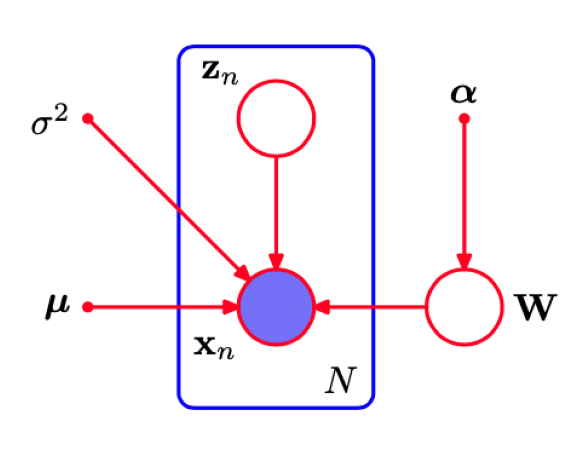

In [16]:
# 图12.13
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.13.png')
plt.axis('off')
ax.imshow(d)

图 12.13 贝叶斯PCA的概率图模型，其中参数矩阵$ W $上的概率分布由超参数向量$ \alpha $控制。

$ \alpha_i $的值可以通过最大化边缘似然函数的方式迭代地求解，其中$ W $被积分出去。作为最优化的结果，某个$ \alpha_i $可能趋于无穷大，对应的参数向量$ w_i $趋于0（后验概率分布变成了原点处的delta函数），得到了一个稀疏解。这样，主子空间的有效的维度由有限的$ \alpha_i $的值确定，对应的向量$ w_i $可以被认为对于数据分布的建模是“有关系的”。通过这种方式，贝叶斯方法自动地在提升数据拟合程度（使用较多的向量$ w_i $以及对应的根据数据调节的特征值$ \lambda_i $）和小模型复杂度（压制某些$ w_i $向量的值）之间进行了折中。这种稀疏性的来源之前在相关向量机的问题中已经讨论过。

$ \alpha_i $的值在训练阶段通过最大化似然函数的方式被重新估计，形式为
$ p(X|\alpha,\mu,\sigma^2) = \int p(X|W,\mu,\sigma^2)p(W|\alpha)dW \tag{12.61} $
其中，$ p(X | W, \mu, \sigma^2) $的对数由式（12.43）给出。注意，为了简化起见，我们也将$ \mu $和$ \sigma^2 $看成待估计的参数，而没有在这些参数上定义先验概率分布。

由于积分无法直接计算，因此我们使用拉普拉斯近似。如果我们假设后验概率分布有尖峰，这种情况对于足够大的数据集确实会发生，那么重估计方程可以通过关于$ \alpha_i $最大化边缘似然函数的方式得到，形式为
$ \alpha_i^{new} = \frac{D}{w_i^Tw_i} \tag{12.62} $
这可以从式（3.98）中推导出来，只需注意到$ w_i $的维度是$ D $即可。这些重新估计过程与确定$ W $和$ \sigma^2 $的EM算法的更新过程交织在一起。与之前一样，E步骤方程由式（12.54）和（12.55）给出。类似的，$ \sigma^2 $的M步骤方程由式（12.57）给出。在M步骤中的唯一的改变是$ W $的方程，它修改后的形式为
$ W_{new} = \left[\sum\limits_{n=1}^N(x_n - \bar{x})\mathbb{E}[z_n]^T\right]\left[\sum\limits_{n=1}^N\mathbb{E}[z_nz_n^T] + \sigma^2A\right]^{-1} \tag{12.63} $
其中$ A = diag(\alpha_i) $。与之前一样，$ \mu $的值为样本均值。

如果我们令$ M = D − 1 $，那么如果所有的$ \alpha_i $是有限值，那么模型表示一个具有完整协方差的高斯模型，而如果所有的$ \alpha_i $区域无穷大，那么模型等价于各向同性的高斯模型，从而模型可以涵盖主子空间的有效维度的所有可能的值。也可以考察较小的$ M $值，这会降低计算量，但是也限制了子空间的最大维度。这个算法与标准的概率PCA算法的对比如图12.14所示。
 


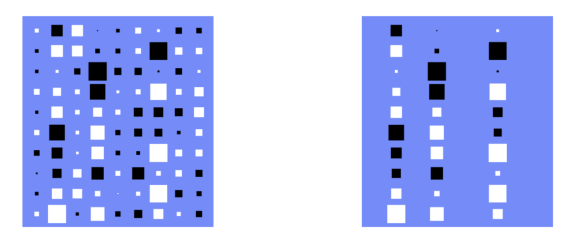

In [17]:
# 图12.14
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.14.png')
plt.axis('off')
ax.imshow(d)

图 12.14 矩阵$ W $的Hinton图，其中矩阵的每个元素被表示为一个正方形，白色表示正值，黑色表示负值，正方形的面积正比于那个元素的大小。人工生成的数据集由300个数据点构成，数据点从一个$ D = 10 $维的高斯分布中采样，高斯分布在3个方向上的标准差为1.0，在剩余的7个方向上的标准差为0.5。数据空间的维度为$ D = 10 $，在$ M = 3 $个方向上的方差大于剩余的7个方向上的方差。左图给出了使用最大似然方法的概率PCA的结果，右图给出了贝叶斯PCA的对应的结果。我们看到通过压制6个多余的自由度的方式来发现维度的合适的值。

贝叶斯PCA使得我们有机会来说明11.3节讨论的Gibbs采样算法。图12.15给出了对超参数$ \ln \alpha_i $采样的例子，数据集的维度为$ D = 4 $，潜在空间的维度为$ M = 3 $，但是数据集通过一个概率PCA模型生成，这个模型在一个方向上的方差较大，剩余方向由较低方差的噪声组成。

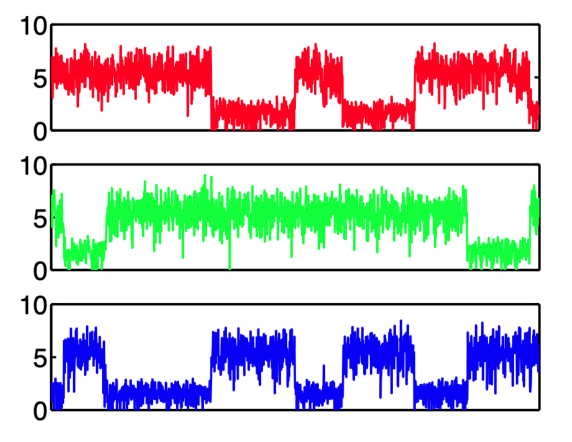

In [18]:
# 图12.15
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.15.png')
plt.axis('off')
ax.imshow(d)

图 12.15 用于贝叶斯PCA的吉布斯采样。图中给出了对于三个不同的$ \alpha $值，$ \ln \alpha_i $关于迭代次数的图像。可以看出在后验概率分布的三个峰值之间的变化。

结果很明显地展示了后验概率分布中三个不同峰值的存在。在每轮迭代中，一个超参数具有较小的值，剩下的两个具有较大的值，因此三个潜在变量中的两个被压制。在吉布斯采样的过程中， 解在三个峰值之间会发生很明显的转移。

这里描述的模型仅仅涉及到矩阵$ W $上的先验概率分布。关于PCA的完整的贝叶斯方法，包括$ \mu, \sigma^2, \alpha $上的先验概率分布，以及使用变分方法的解，可以参考Bishop(1999b)。关于确定PCA模型的合适维度的不同的贝叶斯方法的讨论，可以参考Minka(2001c)。





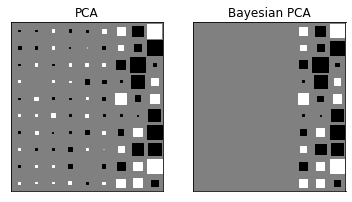

In [6]:
# plot
def create_toy_data(sample_size=100, ndim_hidden=1, ndim_observe=2, std=1.):
    Z = np.random.normal(size=(sample_size, ndim_hidden))
    mu = np.random.uniform(-5, 5, size=(ndim_observe))
    W = np.random.uniform(-5, 5, (ndim_hidden, ndim_observe))

    X = Z.dot(W) + mu + np.random.normal(scale=std, size=(sample_size, ndim_observe))
    return X

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([y - size / 2, x - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    plt.xlim(-0.5, np.size(matrix, 1) - 0.5)
    plt.ylim(-0.5, len(matrix) - 0.5)

X = create_toy_data(sample_size=100, ndim_hidden=3, ndim_observe=10, std=1.)
pca = PCA(n_components=9)
pca.fit(X)
bpca = BayesianPCA(n_components=9)
bpca.fit(X, initial="eigen")
plt.subplot(1, 2, 1)
plt.title("PCA")
hinton(pca.W)
plt.subplot(1, 2, 2)
plt.title("Bayesian PCA")
hinton(bpca.W)

## 12.2.4 因子分析

因子分析是一个线性高斯潜在变量模型，它与概率PCA密切相关。它的定义与概率PCA的唯一差别是给定潜在变量$ z $的条件下观测变量x的条件概率分布的协方差矩阵是一个对角矩阵而不是各向同性的协方差矩阵，即
$ p(x|z) = \mathcal{N}(x|Wz + \mu, \Psi) \tag{12.64} $
其中$ \Psi $是一个$ D \times D $的对角矩阵。注意，与概率PCA模型相同，因子分析模型假设在给定潜在变量$ z $的条件下，观测变量$ x_1,...,x_D $是独立的。本质上讲，因子分析模型这样解释数据的观测协方差结构：表示出矩阵$ \Psi $中与每个坐标相关联的独立的变量，然后描述矩阵$ W $中的变量之间的协方差。在因子分析的文献中，$ W $的列描述了观测变量之间的相关性关系，被称为因子载入（factor loading）。$ \Psi $的对角元素，表示每个变量的独立噪声方差，被称为唯一性（uniqueness）。

因子分析的起源于PCA一样早。关于因子分析的讨论可以参考Everitt(1984)、Bartholomew(1987) 和Basilevsky(1994)。Lawley(1953) 和Anderson(1963) 研究了因子分析与PCA之间的联系，证明了在似然函数的驻点处，对于一个$ \Psi = \sigma^2I $的因子分析模型，$ W $的列是样本协方差的 放缩后的特征向量，$ \sigma^2 $是丢弃的特征值的平均值。后来，Tipping and Bishop(1999b)证明，当组成$ W $的特征向量被选为主特征向量时，对数似然函数取得最大值。使用式（2.115），我们看到观测变量的边缘概率分布为$ p(x) = \mathcal{N}(x|\mu, C) $，其中
$ C = WW^T + \Psi \tag{12.65} $
与概率PCA相同，模型对于潜在空间中的选择具有不变性。历史上，在因子分析中，当我们试图给独立的因子（$ z $空间的坐标）赋予一个直观的意义时，因子分析就变成了争论的焦点。由于潜在空间中的选择不变性，因子分析中存在不可区分的问题，这会造成很多麻烦。然而，从我们的角度来说，我们将因子分析看成一种形式的潜在变量密度模型，其中我们感兴趣的是潜在空间的形式，而不是描述它的具体的坐标系的选择。 如果我们想要移除与潜在空间旋转相关联的模型的退化，那么我们必须考虑非高斯的潜在变量分布，这就产生了独立成分分析（ICA）模型。

我们可以使用最大似然方法确定因子分析模型中的参数$ \mu, W, \Psi $的值。与之前一样，$ \mu $的解是样本的均值。然而，与概率PCA不同，$ W $的最大似然解不再具有解析解，因此必须迭代地求解。由于因子分析是一个潜在变量模型，因此可以使用与概率PCA模型中使用的EM算法相近似的EM算法来计算（Rubin and Thayer, 1982）。具体来说，E步骤方程为
$ \begin{eqnarray} \mathbb{E}[z_n] &=& GW^T\Psi^{-1}(x_n - \bar{x}) \tag{12.66} \\ \mathbb{E}[z_nz_n^T] &=& G + \mathbb{E}[z_n]\mathbb{E}[z_n]^T \tag{12.67} \end{eqnarray} $
其中我们已经定义了
$ G = (I + W^T\Psi^{-1}W)^{-1} \tag{12.68} $
注意，这里使用了一个$ M \times M $的矩阵求逆的表达方式，而不是$ D \times D $的表达方式（除非$ \Psi $是$ D \times D $的对角矩阵，此时求逆很简单，只需$ O(D) $次计算），这通常很方便，因为通常$ M \ll D $。类似的，M步骤方程的形式为
$ \begin{eqnarray} W_{new} = \left[\sum\limits_{n=1}^N(x_n - \bar{x}\mathbb{E}[z_n]^T\right]\left[\sum\limits_{n=1}^N\mathbb{E}[z_nz_n^T]\right]^{-1} \tag{12.69} \\ \Psi_{new} = diag\left{S - W^{new}\frac{1}{N}\sum\limits_{n=1}^N\mathbb{E}[z_n](x_n - \bar{x})^T\right} \tag{12.70} \end{eqnarray} $
其中，“diag”算符将所有非对角线上的元素全部设置为0。使用本书中讨论过的方法，可以很容易的得到因子分析模型的贝叶斯方法。

概率PCA与因子分析的另一个不同点关注的是数据集在变换下的行为的差异。对于PCA和概率PCA来说，如果我们在数据空间中选择坐标系，那么我们对数据的拟合不会发生任何变化， 但是$ W $会使用对应的选择矩阵进行变换。然而，对于因子分析来说，类似的性质是，如果我们对于数据向量进行一个分量之间的重新缩放，那么这种缩放可以被整合到对$ \Psi $的元素的重新缩放之中。



# 12.3 核PCA

在第6章中，我们看到了核替换的方法让我们能够使用形如$ x^Tx' $的标量积表示的算法，并且通过使用一个非线性核替换标量积的方式来对算法进行推广。这里，我们将核替换的方法应用到主成分分析中，从而得到了一个非线性的推广，被称为核PCA(kernel PCA)(Scholkopf etal.， 1998)。

考虑$ D $维空间中的一个观测数据集$ x_n $，其中$ n = 1,...,N $。为了保持记号的简洁，我们假设我们已经从每个$ x_n $中减去了样本的均值，从而$ \sum_n x_n = 0 $。第一步是将传统的PCA表示为这样的形式：数据向量$ {x_n} $只以标量积$ x_n^Tx_m $的形式出现。回忆一下，主成分由协方差矩阵的特征向量$ u_i $定义，即
$ Su_i = \lambda_iu_i \tag{12.71} $
其中$ i = 1,...,D $。这里$ D \times D $的样本协方差矩阵$ S $的定义为
$ S = \frac{1}{N}\sum\limits_{n=1}^Nx_nx_n^T \tag{12.72} $
特征向量被标准化，从而$ u_i^Tu_i = 1 $。现在考虑到一个$ M $维特征空间的一个非线性变换$ \psi(x) $，从而每个数据点$ x_n $被投影到一个数据点$ \psi(x_n) $上。我们现在可以在特征空间上进行标准的PCA，它隐式地在原始数据空间中定义了一个非线性的主成分模型，如图12.16所示。
 

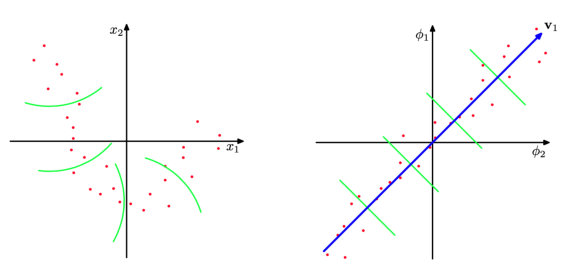

In [19]:
# 图12.16
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.16.png')
plt.axis('off')
ax.imshow(d)


图 12.16 核PCA的图形化说明。原始数据空间中的数据集(左图)被非线性变换$ \psi(x) $投影到特征空间中(右图)。通过在特征空间中执行PCA，我们得到了主成分，其中第一主成分用蓝色表示，记作向量$ v_1 $。特征空间中的绿色直线表示特征空间中在第一主成分上的线性投影，它对应于原始数据空间中的非线性投影。注意，通常不可能在$ x $空间中表示非线性主成分。

现阶段，让我们假设投影数据集的均值也为0，从而$ \sum_n\psi(x_n) = 0 $。我们稍后会回到这里。特征空间中的$ M \times M $样本协方差矩阵为
$ C = \frac{1}{N}\sum\limits_{n=1}^N\psi(x_n)\psi(x_n)^T \tag{12.73} $
它特征向量展开式被定义为
$ Cv_i= \lambda_iv_i \tag{12.74} $
其中$ i = 1,...,M $。我们的目标是求解这个特征值问题，而无需显示的在特征空间中计算。根据$ C $的定义，特征向量方程告诉我们$ v_i $满足
$ \frac{1}{N}\sum\limits_{n=1}^N\psi(x_n){\psi(x_n)^Tv_i} = \lambda_iv_i \tag{12.75} $
因此我们看到（假设$ \lambda_i > 0 $）向量$ v_i $由$ \psi(x_n) $的特征值给出，因此可以写成
$ v_i = \sum\limits_{n=1}^Na_{in}\psi(x_n) \tag{12.76} $
将这个表达式代回到特征向量方程中，我们有
$ \frac{1}{N}\sum\limits_{n=1}^N\psi(x_n)\psi(x_n)^T\sum\limits_{m=1}^Na_{im}\psi(x_m) = \lambda_i\sum\limits_{n=1}^Na_{in}\psi(x_n) \tag{12.77} $
现在关键的步骤是用核函数$ k(x_n，x_m) = \psi(x_n)^T\psi(x_m) $表示上式。我们可以将两侧乘以$ \psi(x_l)^T $，得到
$ \frac{1}{N}\sum\limits_{n=1}^Nk(x_l,x_n)\sum\limits_{m=1}^Na_{im}k(x_n,x_m) = \lambda_i\sum\limits_{n=1}^Na_{in}k(x_l,x_n)\tag{12.78} $
这可以用矩阵的记号表示为
$ K^2a_i = \lambda_iNKa_i \tag{12.79} $
其中$ a_i $是一个$ N $维列向量，元素为$ a_{in} $，其中$ n = 1,...,N $。我们可以通过求解下面的特征值方程
$ Ka_i = \lambda_iNa_i \tag{12.80} $
来找到$ a_i $的解，其中我们已经从方程（12.79）两侧去掉了一个因子$ K $。注意，方程（12.79）和（12.80）的解的唯一差别在于$ K $的那些特征值为零的特征向量，这些特征向量不会影响主成分投影。
系数$ a_i $的标准化条件可以通过要求特征空间的特征向量被归一化的方式得到。使用式（12.76）和（12.80），我们有
$ 1 = v_i^Tv_i = \sum\limits_{n=1}^N\sum\limits_{m=1}^Na_{in}a_{im}\psi(x_n)^T\psi(x_m) = a_i^TKa_i = \lambda_iNa_i^Ta_i \tag{12.81} $
解出了特征向量方程之后，得到的主成分投影也可以根据核函数进行转化。使用式（12.76），点x在特征向量$ i $上的投影为
$ y_i(x) = \psi(x)^Tv_i = \sum\limits_{n=1}^Na_{in}\psi(x)^T\psi(x_n) = \sum\limits_{n=1}^Na_{in}k(x,x_n) \tag{12.82} $
从而我们又一次得到了根据核函数进行表示的形式。 在原始的$ D $维$ x $空间中，有$ D $个正交的特征向量，因此我们最多可以找到$ D $个线性主成分。然而特征空间的维度$ M $可以比$ D $大得多，甚至可以是无穷大，因此我们可以找到多于$ D $个非线性主成分。但是注意，非零特征值的数量不能超过数据点的数量$ N $，因为（即使$ M > N $）特征空间中的协方差矩阵的秩最大等于$ N $。这可以从下面的事实中反映出来：核PCA涉及到对$ N \times N $矩阵$ K $的特征向量展开。

目前为止，我们假设由$ \psi(x_n) $给出的投影数据集的均值为0，通常的情况并非如此。我们不能简单地计算然后减去均值，因为我们希望避免直接在特征空间中进行计算，因此我们完全根据核函数来建立算法的公式。在中心化之后，投影的数据点（记作$ \tilde{\psi}(x_n) $）为
$ \tilde{\psi}(x_n) = \psi(x_n) - \frac{1}{N}\sum\limits_{l=1}^N\psi(x_l) \tag{12.83} $
从而Gram矩阵的对应元素为
$ \begin{eqnarray} \tilde{K}{nm} &=& \tilde{\psi}(x_n)^T\tilde{\psi}(x_m) \ &=& \psi(x_n)^T\psi(x_m) - \frac{1}{N}\sum\limits{l=1}^N\psi(x_n)^T\psi(x_l) \ & & -\frac{1}{N}\sum\limits_{l=1}^N\psi(x_l)^T\psi(x_m) + \frac{1}{N^2}\sum\limits_{j=1}^N\sum\limits_{l=1}^N\psi(x_j)^T\psi(x_l) \ &=& k(x_n,x_m) - \frac{1}{N}\sum\limits_{l=1}^Nk(x_l,x_m) \ & & -\frac{1}{N}\sum\limits_{l=1}^Nk(x_n,x_l) + \frac{1}{N^2}\sum\limits_{j=1}^N\sum\limits_{l=1}^Nk(x_j,x_l) \tag{12.84} \end{eqnarray} $
使用矩阵的记号，这个结果可以表示为
$ \tilde{K} = K - 1_NK - K1_N + 1_NK1_N \tag{12.85} $
其中$ 1_N $表示$ N \times N $的矩阵，它的每个元素的值都是$ 1 / N $。因此，我们可以只使用核函数来计算$ \tilde{K} $，然后使用$ \tilde{K} $确定特征值和特征向量。注意，如果我们使用线性核$ k(x, x') = x^Tx' $，那么我们就恢复出了标准的PCA算法。图12.17给出了核PCA应用于人工生成数据集的一个例子（Scholkopf et al.， 1998）。

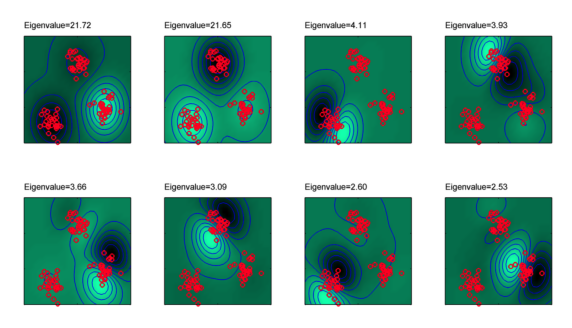

In [20]:
# 图12.17
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.17.png')
plt.axis('off')
ax.imshow(d)

图 12.17 使用高斯核的核PCA用于二维空间的人工生成数据集的例子，图中画出了前8个特征函数以及对应的特征值。轮廓线表示沿着曲线的方向，在对应的主成分上的投影是常数的轮廓线。注意前两个特征向量将三个聚类划分开，接下来的三个特征向量将每个聚类分成一两半，再接下来的三个特征向量再次将聚类划分为两半，方向是沿着与之前的划分正交的方向。

这里，我们将一个“高斯”核
$ k(x,x') = exp\left(-\frac{\Vert x - x' \Vert^2}{0.1}\right) \tag{12.86} $
应用于人工生成数据集。图中的曲线对应于沿着曲线方向，在对应的主成分上投影为常数的等高线，投影的定义为
$ \psi(x)^Tv_i = \sum\limits_{n=1}^Na_{in}k(x,x_n) \tag{12.87} $
核PCA的一个明显的缺点是它涉及到寻找$ N \times N $矩阵$ \tilde{K} $的特征向量，而不是传统的线性PCA中$ D \times D $的矩阵$ S $的特征向量，因此在实际应用中，对于较大的数据集，我们经常会使用近似。

最后，我们注意到在标准的线性PCA中，我们通常保留$ L < D $个特征向量，然后使用数据向量$ x_n $在$ L $为主子空间上的投影$ x_n $来近似数据向量$ x_n $，投影的定义为
$ \hat{x}n = \sum\limits{i=1}^L(x_n^Tu_i)u_i \tag{12.88} $
在核PCA中，这通常是不可能的。为了说明这一点，我们注意到映射$ \psi(x) $将$ D $维$ x $空间映射到了$ M $维特征空间$ \psi $中的一个$ D $维流形（manifold）中。向量x被称为对应点$ \psi(x) $的原像（preimage）。然而，特征空间中的点在特征空间的线性PCA子空间中的投影通常不会位于非线性$ D $维流形中，因此在数据空间中不会存在一个对应的原像。于是，研究者们提出了一些寻找近似原像的方法(Bakir et al.，2004)。



# 12.4 非线性隐含变量模型

本章中，我们将注意力集中与带有连续潜在变量的最简单的一类模型上，即基于线性高斯分布的模型。这些模型在实际应用中很重要，并且这些模型相对容易分析，容易拟合数据，也可以用作更复杂模型的基本成分。这里，我们简要讨论一下对这个框架的一些推广，推广到非线性的模型，或者非高斯的模型，或者二者兼具的模型。

实际上，非线性性质和非高斯性质是相互关联的，因为一般的概率密度可以从一个简单的固定的参考概率密度(例如高斯分布)中得到，只需对变量进行非线性变换即可。这个想法构成了几个实际应用中的潜在变量模型的基础，正如我们将看到的那样。

## 12.4.1 独立成分分析

首先，我们考虑观测变量与潜在变量线性相关的模型，但是潜在概率分布不是高斯分布。这种模型的一个重要的类别被称为独立成分分析（independent component analysis），或者ICA。 如果我们考虑潜在变量上的概率分布的分解，即
$ p(z) = \sum\limits_{j=1}^Mp(z_j) \tag{12.89} $
那么我们就会应用到这个模型。为了理解这种模型的作用，考虑这样一个场景：两个人同时讲话，我们使用两个麦克风来记录他们的声音。如果我们忽略诸如时间延迟和回声之类的影响，那么在任意时间点，麦克风接收到的信号都是两个声音的振幅的线性组合。这个线性组合的系数是常数，并且如果我们可以从采样数据中推断它们的值，那么我们就可以将混合的过程（假设非奇异）进行求逆，从而得到两个干净的信号，每个信号只包含一个人的声音。这是盲源划分（blind source separation）问题的一个例子，其中，“盲”表示我们只给定了混合数据，而原始 的数据源和混合系数都没有被观测到（Cardoso， 1998）。

这类问题有时使用下面的方法解决（MacKay， 2003），其中我们忽略信号的时序本质，将连续的样本看成是独立同分布的。我们考虑一个生成式模型，其中有两个潜在变量，对应于未观测的语音信号的幅值，有两个观测变量，由麦克风的信号值给定。潜在变量的联合概率分布可以按照上面的方式分解，观测变量由潜在变量的线性组合给定。我们无需引入一个噪声分布，因为潜在变量的数量等于观测变量的数量，从而观测变量的边缘概率分布通常不会是奇异的，因此观测变量仅仅由潜在变量的线性组合确定。给定一组观测数据，模型的似然函数是线性组合的系数的一个函数。对数似然函数可以使用基于梯度的最优化方法进行最大化，得到了独立 成分分析的一个特定的版本。

这种方法的成功需要令潜在变量具有非高斯的概率分布。为了说明这一点，回忆一下在概率PCA（以及因子分析）中，潜在空间分布是一个零均值的各向同性的高斯分布。于是，模型 无法区分那些区别仅仅在于潜在空间的旋转的潜在变量的不同选择。这一点可以用下面的方法直接验证：我们注意到边缘概率密度（12.35）在变换$ W \to WR $下是不变的，因此似然函数也是不变的，其中$ R $是正交矩阵，满足$ RR^T = I $，这是因为式（12.36）给出的矩阵$ C $本身是不变的。将这个模型进行扩展，使得更多的概率潜在分布被包含到模型中，结论不会改变，因为正如我们已经看到的那样，这种模型等价于零均值各向同性的高斯潜在变量模型。

我们用另一种方式说明为什么线性模型中的高斯潜在变量分布对于找到独立的成分是不够的。我们注意到，主成分表示数据空间中的坐标系的一个旋转，从而对协方差矩阵进行了对角化，因此新的坐标系中的数据分布没有相关性。虽然不具有相关性是独立性的一个必要条件，但是它不是充分条件。在实际应用中，潜在变量分布的一个常见的选择是
$ p(z_j) = \frac{1}{\pi cosh(z_j)} = \frac{2}{\pi(e^{z_j} + e^{-z_j})} \tag{12.90} $
这与高斯分布相比，具有长尾的性质，这反映了许多现实世界中的概率分布同样具有这种性质。

最初的ICA模型（Bell and Sejnowski， 1995）基于的是由信息最大化定义的目标函数的最优化过程。概率潜在变量形式的一个优点是它有助于对基本ICA的推广进行形式化描述。例如，独立因子分析（independent factor analysis）研究的是这样的模型：潜在变量的数量和观测变量的数量可以不同，观测变量带有噪声，各个潜在变量的概率分布很灵活，由混合高斯模型建模。这个模型的对数似然函数使用EM算法进行最大化，潜在变量的重建使用变分方法进行近似。研究者们也在研究许多其他类型的模型，现在有许多文献研究ICA及其应用（Jutten and Herault， 1991; Comon et al.， 1991; Amari et al.， 1996; Pearlmutter and Parra， 1997; Hyvarinen Oja， 1997; Hinton et al.， 2001; Miskin and MacKay， 2001; Hojen-Sorensen et al.， 2002; Choudrey and Roberts， 2003; Chan et al.， 2003; Stone， 2004）。

## 12.4.2 自关联网络

在第5章中，我们在有监督学习的环境中研究了神经网络，其中网络的左右是在给定输入变量值的条件下预测输出。然而，神经网络也被应用于无监督学习，此时神经网络用于维度降低。使用输出结点与输入结点数量相同的神经网络，通过最优化权值来最小化某种度量，这种度量描述了在训练数据集上，输入和输出之间的重建误差。

首先，考虑图12.18所示的多层感知器网络，它有$ D $个输入，$ D $个输出，以及$ M $个隐含单元， 其中$ M < D $。用来训练网络所使用的目标棉量仅仅是输入向量本身，因此网络试图将输入向量映射到它本身上。

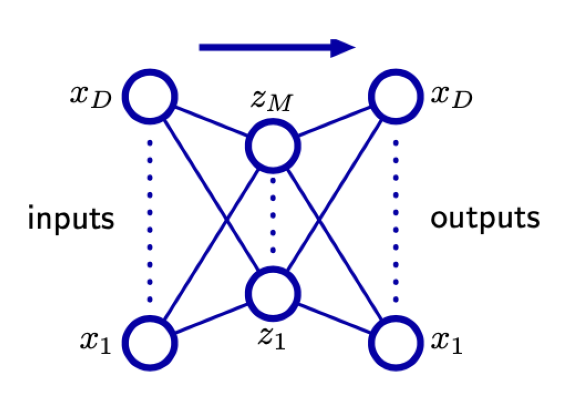

In [21]:
# 图12.18
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.18.png')
plt.axis('off')
ax.imshow(d)


 
图 12.18 一个自相关的多层感知器网络，具有两层权值。这样的一个网络通过最小化平方和误差的方式 进行训练，得到从输入向量到其自身的一个映射。即使隐含层是非线性单元，这样一个网络也等价于线性主成分分析。为了清晰，表示偏置参数的链接已经被略去。

这样的网络构成了一个自相关映射（autoassociative mapping）。由于隐含单元的数量小于输入的数量，因此将所有的变量进行一个完美的重建通常是不可能的。于是，我们通过最小化一个误差函数的方式来确定网络的参数$ w $，这个误差函数描述了输入向量和它们的重建之间的不匹配程度。特别地，我们会现在一个平方和误差函数，形式为
$ E(w) = \frac{1}{2}\sum\limits_{n=1}^N\Vert y(x_n,w) - x_n \Vert^2 \tag{12.91} $
如果隐含单元具有线性激活函数，那么可以证明误差函数有唯一的全局最小值，在这个最小值处，网络实现了到一个M维子空间上的投影，这个子空间由数据的前M个主成分张成（Bourland and Kamp，1988; Baldi and Hornik，1989）。因此，图12.18的隐含单元的权向量构成了张成主子空间的基的集合。但是，注意，这些向量不需要正交或标准化。这个结果毫不令人惊讶，因为主成分分析和神经网络都使用了线性维度降低、并且最小化相同的误差函数。
可能我们会认为，线性维度降低的局限性可以在网络的隐含单元中使用图12.18中的非线性（sigmoid）激活函数的方式来克服。但是，即使使用非线性隐含单元，误差函数的最小值同样通过在主子空间上投影的方式获得（Bourlard and Kamp，1988）。于是使用两层神经网络在维度降低方面没有优势。主成分分析的标准方法（基于奇异值分解）保证在有限时间内给出正确的解，并且这种方法也产生了特征值的一个有序集合，对应于单位正交的特征向量。
然而，如果网络中有额外的隐含层，情况就会有所不同。考虑图12.19给出的四层自相关网络。
 

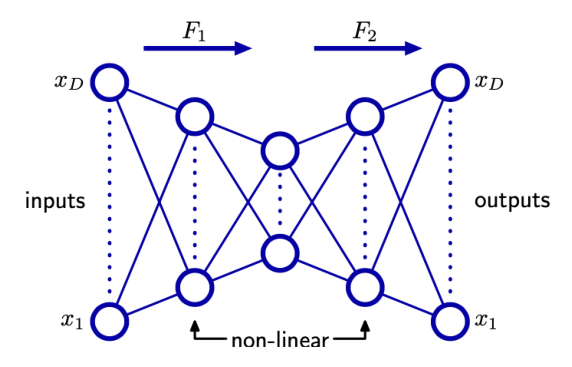

In [22]:
# 图12.19
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.19.png')
plt.axis('off')
ax.imshow(d)


图 12.19 增加额外的非线性单元组成的隐含层产生了一个能够进行非线性维度降低的自相关网络。

与之前一样，输出单元是线性的，在第二个隐含层的$ M $个单元也可以是线性的，但是第一个隐含层和第三个隐含层具有sigmoid非线性激活函数。网络同样用最小化误差函数（12.91）的方式确定。我们可以将这个网络看成两个连续的函数映射$ F_1 $和$ F_2 $，如图12.19所示。第一个映射$ F_1 $将原始的$ D $维数据映射到$ M $为子空间$ S $上，这个子空间由第二个隐含层的单元的激活所定义。由于第一个非线性单元隐含层的存在，因此这个映射非常一般，并且特别地，这个映射不限于线性映射。类似地，网络的第二部分定义了从$ M $维空间到原始$ D $为输入空间中的一个任意的函数映射。这种映射有一个很简单的几何意义，图12.20给出了$ D = 3 $和$ M = 2 $的情形。
 



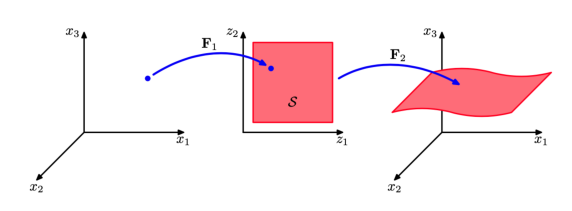

In [23]:
# 图12.20
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.20.png')
plt.axis('off')
ax.imshow(d)

图 12.20 图12.19的网络表示的映射的集合表示，其中输入单元的数量为$ D = 3 $，中间隐含层单元的数量为$ M = 2 $。函数$ F_2 $表示从$ M $维空间$ S $到$ D $维空间的一个映射，因此定义了空间$ S $嵌入到原始$ x $空间的方式。由于映射$ F_2 $可以是非线性的，因此$ S $嵌入的空间可以不是平面，如图所示。这样，映射$ F_1 $定义了原始$ D $维空间中的一个点到$ M $维子空间$ S $中的投影。

这样的网络能够有效地完成非线性主成分分析。它的优点在于，不局限于线性变换，虽然标准的主成分分析是它的一个具体的例子。然而，现在训练这个神经网络涉及到非线性最优化问题，因为误差函数（12.91）不再是网络参数的二次函数。我们必须使用需要大量计算的非线性最优化方法，并且有找到误差函数的局部极小值的风险。并且，子空间的维度必须在训练网络之前指定。

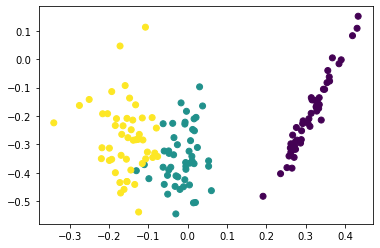

In [7]:
# plot
autoencoder = Autoencoder(4, 3, 2)
autoencoder.fit(iris.data, 10000, 1e-3)
Z = autoencoder.transform(iris.data)
plt.scatter(Z[:, 0], Z[:, 1], c=iris.target)
plt.show()

## 12.4.3 对非线性流形建模

正如我们已经注意到的那样，许多自然的数据源对应于低维的可能带有噪声的非线性流形，这些流形镶嵌在更高维的观测数据空间中。显式地利用这个性质可以产生与一般的方法相比更好的概率密度模型。这里，我们简要讨论尝试完成这一点的几种方法。

对这种非线性结构建模的一种方法是通过线性模型的组合，从而我们对流形做了一个分段线性的近似。这个近似可以通过使用诸如K均值的聚类方法，基于欧几里得距离，将数据集划分为若干个局部的分组，对每个分组分别使用标准的PCA。一种更好的方法是使用聚类分配的重建误差（Kambhatla and Leen， 1997; Hinton et al.， 1997），然后在每个阶段优化一个共同的代价函数。然而，这些方法会由于我们无法得到整体的概率密度模型而产生局限性。通过使用概率PCA，很容易定义一个完整的概率模型，只需考虑一个混合的概率分布，每个分量都是概 率PCA即可（Tipping and Bishop， 1999a）。这样的模型既包含离散潜在变量，对应于离散的混合，也包含连续的潜在变量，以及可以使用EM算法最大化的似然函数。基于变分推断的纯粹的 贝叶斯方法（Bishop and Winn， 2000）使得混合分量的个数以及各个模型的有效维度可以从数据中进行推断。这个模型有很多变体，例如将诸如$ W $矩阵或噪声方差之类的参数与混合分量相关联，或者将各向同性噪声概率分布替换为对角的噪声概率分布，这就引出了因子分析的混合（Ghahramani and Hinton， 1996a; Ghahramani and Beal， 2000）。概率PCA模型的混合也可以层次化地扩展，产生了一个很有吸引力的数据可视化算法（Bishop and Tipping， 1998）。




另一种处理方式是直接考虑一个单一的非线性模型，而不是将线性模型混合。回忆一下，传统的PCA寻找一个线性子空间，这个子空间在最小平方的意义下能够以最近的距离通过 数据集。这个概念可以推广到一维非线性曲面，被称为主曲线（principal curve）（Hastie and Stuetzle， 1989）。我们可以使用一个向量值的函数$ f(\lambda) $来描述$ D $维数据空间中的一条曲线。这个函数的函数值是一个向量，向量的元素是标量$ \lambda $的一个函数。有许多种可能的方式来参数化这条曲线，其中一种自然的选择是沿着曲线的弧的长度。对于数据空间中的任意给定的点$ \hat{x} $，我们可以在曲线上寻找一个点，它距离数据点的欧几里得距离最小。我们将这个点记作$ \lambda = g_f(x) $，因为它依赖于一个特定的曲线$ f(\lambda) $。对于一个连续的数据概率密度$ p(x) $，一个主曲线被定义为这样的曲线：曲线上的每个点都是数据空间中那些投影到这个点的所有点的均值，即
$ \mathbb{E}[x|g_f(x) = \lambda] = f(\lambda) \tag{12.92} $
对于一个给定的连续概率密度，可能存在多个主曲线。在实际应用中，我们感兴趣的是有限的数据集，并且我们还希望将注意力集中于光滑的曲线。Hastie and Stuetzle（1989）提出了一个两阶段的迭代步骤来寻找这种主曲线，与用于PCA的EM算法有些相似。曲线使用第一主成分进行初始化，然后算法在数据投影步骤和曲线重估计步骤之间交替进行。在投影步骤中，每个数据点被赋一个$ \lambda $值，对应于曲线上距离最近的点。然后，在重估计步骤中，曲线上的每个点都是那些投影到曲线上附近点的一个加权平均，距离曲线最近的点的权重最大。在子空间是线性的情况下，算法收敛于第一主成分，等价于寻找协方差矩阵最大特征向量的幂方法。主曲线可以推广到多维流形中，这个流形被称为主曲面（principal surface），但是主曲面的用途很有限，因为高维空间的数据平滑很困难，即使对于二维流形也是如此。


PCA经常被用于将数据集投影到低维空间中，例如二维空间中，用于数据的可视化。另一个目的很相似的线性方式是多维放缩（multidimensional scaling）或者被称为MDS（Cox and Cox， 2000）。这种方法寻找数据的一个低维投影，同时使得数据点之间的距离尽可能的近。这种方法需要寻找距离矩阵的特征向量。在距离的度量是欧几里得距离的情况下，它等价 于PCA。MDS的概念可以推广到相当广泛的一大类数据类型中，这些数据类型根据相似度矩阵 定义，得到了非度量MDS（nonmetric MDS）。

维度降低和数据可视化的另外两个非概率方法很值得一提。局部线性嵌入（locally linear embedding）或者LLE（Roweis and Saul，2000）首先计算系数的集合，这些系数能够最好地从每个数据点中重建出它的相邻点。这些系数的设置使其对于数据点和相邻点的旋转、平移、缩放 具有不变性，因此系数描述了相邻点的几何性质的特征。然后，LLE将高维数据点映射到低维空间中，同时保持这些邻域的系数。如果对于一个特定的数据点，局部的邻域可以被当做线性的，那么变换可以使用平移、旋转、缩放的组合来实现，从而保持数据点和它们的邻域之间的角度。由于权值对于这些变换具有不变性，因此我们预计重建低维空间的数据点和高维空间的数据点所需的权值相同。尽管具有非线性性质，对于LLE的优化不会有局部的极小值。

在等尺度特征映射（isometric feature mapping）或者isomap（Tenenbaum et al.， 2000）中，目标是将数据点使用MDS投影到低维空间中，但是不相似度根据在流形上测量的曲面距离 （geodesic distance）定义。例如，如果两个数据点位于一个圆上，那么曲面距离是沿着圆周测量的弧的长度，而不是沿着连接两点的弦的直线距离。首先，算法定义每个数据点的邻域，方法是寻找$ K $个最近邻，或者寻找在一个半径为ε的球体内部的点。然后，通过将所有的邻域点进行连接，然后使用欧几里得距离标记这些距离，就可以构建出一个图。之后，任意点对之间的 曲面距离通过对沿着连接它们的最短路径的弧的长度进行求和的方式得到。最后，有度量的MDS被应用于曲面距离矩阵上，用来寻找低维的投影。

我们在本章中关注的对象是观测变量为连续变量的模型。我们也可以考虑具有连续潜在变量以及离散官色变量的模型，这就产生了潜在特征模型（latent trait model）（Bartholomew， 1987）。在这种情况下，连续潜在变量上的积分无法解析地计算，即使潜在变量与观测变量之间具有线性关系的时候也是如此，因此我们需要更复杂的技术。Tipping（1999）在一个具有二维潜在空间的模型中使用变分推断方法，使用一个二值的数据集可以进行可视化，这与使用PCA对连续数据可视化的情形类似。注意，这个模型是4.5节讨论的贝叶斯logistic回归问题的对偶问题。在logistic回归的情形中，我们有特征向量φn的N次观测，特征向量使用一个单一的权向量w进行参数描述，而在潜在空间可视化模型中，存在一个单一的潜在空间变量x（类似 于φ）以及潜在变量wn的N个副本。Collins et al.（2002）将概率潜在变量模型推广到了一般的 指数族分布的情形。

我们已经注意到，通过使用一个恰当的非线性变换作用于高斯随机变量上，我们可以建立任意的概率分布。这个结论被用于更一般的潜在变量模型中，被称为密度网络（density network） （MacKay， 1995; MacKay and Gibbs， 1999），其中非线性函数由多层神经网络控制。如果网络有足够多的隐含结点，那么它能够以任意的精度近似给定的非线性函数。如此灵活的模型的一个负面效果是，似然函数所需的潜在变量上的积分无法解析地计算。相反，似然函数可以通过从高斯先验概率分布中采样，使用蒙特卡罗方法近似。这样，在潜在变量上的积分变成了一个简单的求和，求和式中的每一项对应于一个样本。然而，由于为了得到边缘概率分布的一个准 确的表示，我们需要相当多的数据点，因此这个方法的计算代价很高。

如果我们考虑非线性函数的一个更加受限的形式，并且恰当地选择离散变量概率分布，那么我们可以建立一个离散变量模型，这个模型是非线性的，并且训练上很高效。生成式地形映 射（generative topographic mapping）或者GTM（Bishop et al.， 1996; Bishop et al.， 1997a; Bishop et al.， 1998b）使用一个潜在的概率分布，这个概率分布由潜在空间（通常是二维的）上的delta函数的有限个正规格点定义。这样，在这个潜在空间中的积分只需对每个格点位置上的贡献进行求和即可。非线性映射由一个线性回归模型给出，这个线性模型允许一般的非线性性质，同时使得映射是可调节参数的一个线性函数。注意，由于维度灾难造成的线性回归模型的局限性在GTM中没有出现，因为流形通常具有两个维度，与数据空间的维度无关。这两种选择的一个结果是似然函数可以用封闭的形式解析地表示，可以使用EM算法高效地最优化。生成的GTM模型将一个二维的非线性流形按照数据集进行调节，并且通过计算数据点的潜在空间上的后验概率分布，数据点可以映射回潜在空间，用于数据的可视化。图12.21给出了使用线性PCA和非线性GTM对石油流数据进行可视化的对比。
 

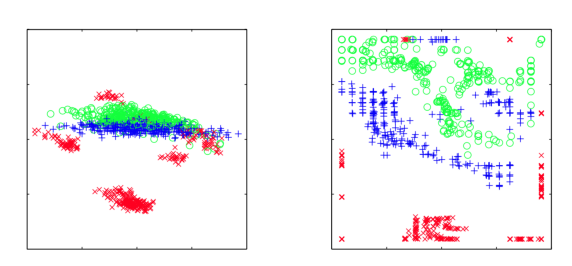

In [24]:
# 图12.21
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.21.png')
plt.axis('off')
ax.imshow(d)


图 12.21 使用PCA(左图)和GTM(右图)对石油流数据集进行可视化。对于GTM模型，每个数据点都画在了潜在空间的后验概率分布的均值位置。GTM模型的非线性性质使得数据点分组之间的划分可以更明显地看出。

GTM可以被看成一个更早的模型的概率化版本，这个模型被称为自组织映射（self organizing map），或者SOM（Kohonen， 1982; Kohonen， 1995），它也将二维非线性流形表示为离散点的正规数组。SOM与K均值算法有些相似，因为数据点被分配到附近的代表向量中，然后被更新。初始阶段，代表向量被随机分布。在训练阶段，它们“自组织”，来近似一个光滑的流形。然而，与K均值不同，SOM没有优化任何具有良好定义的代价函数（Erwin et al.， 1992），使得设置模型的参数以及评估收敛变得十分困难。并且不能保证“自组织”会发生，因为它依赖于对于特定数据集的恰当的参数选择。

相反，GTM最优化对数似然函数，得到的模型定义了数据空间的一个概率密度。事实上，它对应于一个受限的高斯混合，其中各个分量共享一个相同的方差，均值被限制在一个光滑的二维流形中。概率的基础也使得定义GTM的推广形式很容易（Bishop et al.， 1998a），例如处理 缺失值的贝叶斯方法，对离散变量的一个系统化的推广，使用高斯过程来定义流形，或者层次化GTM模型（Tino and Nabney， 2002）。

由于GTM中的流形被定义为连续曲面，而不像SOM那样仅仅定义一个代表向量，因此可以 计算放大因子（magnification factor），对应于拟合数据集时所需的对流形的局部放大或压缩 （Bishop et al.， 1997b），也可以计算方向曲率（directional curvature）（Tino et al.， 2001）。可 以使用投影数据进行可视化，并且使我们能够更深刻地认识这个模型。


